## 1D PIC (evolution_version_relativistic) Landau Damping

Here we compute the 1D version of PIC. 
The initial distribution we use corresponds to a particles in a thermal bath with a given temperature and a spatial distribution given by a cosine function over a background.
The distribution is:

$$
f(x,v) = \frac{N}{L} \frac{1}{\sqrt{2\pi\theta}} e^{\frac{1 - \sqrt{1 + p^2}}{\theta}}(1 + \alpha cos(kx))
$$

We shall use $\theta = 0.001$, $\alpha = 0.01$ (some with $\alpha = 0.1$ for fun).

The normalization factors are not important because we then normalize the momentums of the distribution.

In [1]:
#using DifferentialEquations
using Plots
using Statistics
using FFTW
FFTW.set_provider!("mkl")
#import Pkg; Pkg.add("FileIO")
using FileIO
using JLD2
using Base.Threads
using Distributions
#Pkg; Pkg.add("DistributedArrays")
println("nthreads = $(nthreads())")
using Printf
#import Pkg; Pkg.add("IJuliaBell")
using IJuliaBell

nthreads = 2


Helper functions are defined in this file.

In [2]:
include("aux_functions.jl")
include("inidat_aux_functions.jl")

f_x_max (generic function with 1 method)

In [3]:

undamped_l = false
undamped_s = false
damped = false
vlasov_exp_200 = false
vlasov_exp_40 = false
#undamped_s = true
damped = true
#vlasov_exp_40 = true
#vlasov_exp_200 = true

true

In [4]:
run_name = "norel_norm_"
data_name = "par_dis_landau_norm_norel_"
if undamped_l
    const L = 39.738 
    const J = 3522
    nm = 2 # this is defined again in inidat lambda = L/nm = 19.869
    #nm = 20
    data_name = data_name * "undamped_l_$(nm)_"
    run_name = run_name * "undamped_rel_"
elseif undamped_s
    const L = 4
    const J = 80
    nm = 2 # this is defined again in inidat lambda = L/nm = 2 which gives a k approx 0.1
    #nm = 20
    data_name = data_name * "undamped_s_$(nm)_"
    run_name = run_name * "undamped_rel_"
elseif damped
    const L = 7.455
    const J = 930
    nm = 15 # this is defined again in inidat lambda = L/nm = 0.497
    data_name = data_name * "damped_$(nm)_"
    run_name = run_name * "damped_rel_"
elseif vlasov_exp_200
    const L = 200
    const J = 2000
    #const nm = 10 # para comparar con 40_2 
    const nm = 2 # this is defined again in inidat lambda = L/nm = 100
    data_name = data_name * "vla_200_$(nm)_"
    run_name = run_name * "vla_200rel_"
elseif vlasov_exp_40
    const L = 40
    const J = 400
    const nm = 2 # this is defined again in inidat lambda = L/nm = 20
    data_name = data_name * "vla_40_$(nm)_"
    run_name = run_name * "vla_40_rel_"
end

order = 4

exp_alpha = 2
α = 10.0^(-exp_alpha)

N_exp = 6 #6
N = 8*10^(N_exp)
exp_Theta = 3
θ = 10.0^(-exp_Theta)

@show data_name = data_name * "alp$(exp_alpha)_8$(N_exp)_Th$(exp_Theta)"

exp_t = 2 #2
t = 0.0
t_i = 0.0
t_f = 4*10.0^(exp_t)
M = 16001# 4001 # 81 # 2001 # time steps 
M_g = 8001 #400 + 1 #number of outputs, starting from the initial data

κ = 2π/L # for Fourier Transform
dx = L/J
x = [dx*(i-1) for i in 1:J] ;
#p = (L, N, J, κ, dx, order)
dt = (t_f-t_i) / (M-1)
@show par_evolv = (t_i, t_f, M, M_g, dt)
@show par_grid = (N, L, J, dx, order)
@show pars_f = (θ, nm, κ)
par_init = (α, 2π*nm/L)


println("t_f = $(t_f), M = $M, dt = $(dt), exp_Theta = $(exp_Theta)")



run_name = run_name * "t$(convert(Int,t_f))_L$(L)_N8$(N_exp)_n$(nm)_J$(J)_M$(M)_o$(order)_Th$(exp_Theta)_alp$(exp_alpha)"
println(run_name)

        
#test_parameters(M, M_g, dt, 0.0, t_f)

data_name = data_name * "alp$(exp_alpha)_8$(N_exp)_Th$(exp_Theta)" = "par_dis_landau_norm_norel_damped_15_alp2_85_Th3"
par_evolv = (t_i, t_f, M, M_g, dt) = 

(0.0, 40.0, 16001, 8001, 0.0025)
par_grid = (N, L, J, dx, order) = (800000, 7.455, 930, 0.008016129032258065, 4)
pars_f = (θ, nm, κ) = 

(0.001, 15, 0.8428149305405213)
t_f = 40.0, M = 16001, dt = 0.0025, exp_Theta = 3
norel_norm_damped_rel_t40_L7.455_N85_n15_J930_M16001_o4_Th3_alp2


In [5]:
par_dis, data_name_from_inidat, pars, par_f_x, par_f_p = retrieve_initial_data("Initial_Distributions/" * data_name * ".jld2")

@show data_name_from_inidat, pars, par_f_x, par_f_p

(data_name_from_inidat, pars, par_f_x, par_f_p) = ("par_dis_landau_norm_norel_damped_15_alp2_85_Th3", (800000,), (0.010000000000000002, 15, 7.455), (0.001, 1.0003670751902618))


("par_dis_landau_norm_norel_damped_15_alp2_85_Th3", (800000,), (0.010000000000000002, 15, 7.455), (0.001, 1.0003670751902618))

In [6]:
average_outputs = true # detailed output (for runs which are too long)
full_outputs = false
animation = false # to run animations
phase_space_show = false #show phase space diagrams
phase_space_show = true
remote_server = false # if run in remote_server as a script avoid all plots 
save_plots = false # put true is you want so save your plots.

false

We have some extra quantities that are proper of the plasma:

The plasma frequency and the Debye temperature:

The plasma frequency is adjusted so that it is unit in with respect to the time units 
taken, space it taken so that the speed of light is one. 
$$
\omega_p^2 = 1
$$

This implies that the background density is $N/L$

In the paper they say the temperature is set to $\theta_D = dx^2$. 

This I don't understand yet.

$$
\lambda_D^2 := \frac{\epsilon_0 \theta_D L}{e^2 N_e} = \frac{\theta_D L}{N_e}
$$

If we set $\lambda_D = dx$ then, 

$$
\theta_D = \frac{N_e dx^2}{L} = \frac{N_e L}{J^2}
$$

For N = 20000, L = 5, J = 50, $\theta_D = 20000 * 5 / 2500 = 400$ ????

I think that actually we set the density to one, so that $\frac{N_e}{L} = 1$ irrespective on how many particles we take. 
That way $\theta_D = \lambda_D^2$



## Code parameters:

$\hat{k} = \frac{k}{\sqrt{\theta}}$

### Undamped
Thus, for $L = 39.738$, $J = 3522$, $\theta = 0.001$, $m = 2$ (second mode)

we have: $dx = 0.01128$, $k=\frac{4\pi}{L} = 0.3162305 $, $\hat{k} = 4*π /  39.738  * \sqrt{0.001} = 0.010000$

For this case the frequency should be: $\omega = 1.00015$


### Damped
Thus, for $L= 7.455$, $J = 930$, $\theta = 0.001$, $m = 15$

we have: $dx = 0.008$, $k=\frac{15*2\pi}{L} = 12.642 $, $\hat{k} = k  * \sqrt{0.001} = 0.399$

For this case the frequency should be: $\omega = 1.2855 - i 0.06613$


We build the initial data:

In [7]:
E_i = zeros(J)
ϕ = zeros(J)
n = zeros(J) #charge density
S = zeros(J) #carge current
du = zeros(2*N+J); # contains r, v and E

With the particle distribution we construct the initial data for the electric field. For that first we compute de density, using different types of particles (order).

In [8]:
get_density!(par_dis, n, par_grid)
get_ϕ!(ϕ, n .- 1., κ)
get_E_from_ϕ!(ϕ,E_i,dx)
u = [par_dis;E_i];
length(u)

1600930

### What follows are characterizations of the initial data properties.

In [9]:
get_current_rel!(u, S, par_grid)

println(maximum(u[1:N]))
println(minimum(u[1:N]))

Coordinate_test(u[1:N],L)

println("n_total = $(sum(n .- 1.0))")
println("v_total = $(sum(u[N+1:2N]))")
println("E_total = $(sum(E_i))")

println("S_total = $(sum(S))")

7.454991214261885
1.74054835380133e-5


n_total = 8.459899447643693e-14
v_total = 0.0
E_total = 1.0061396160665481e-16
S_total = -5.815660453212246e-16


Compute the initial density, potential and electric field.

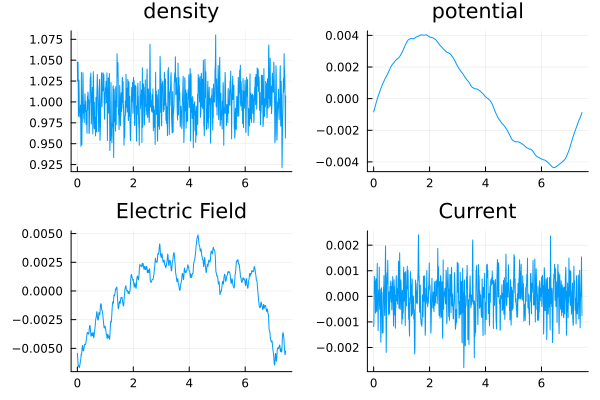

In [10]:
if !remote_server 
    plt = plot(layout=(2,2))
    plot!(subplot=1,x,n, title = "density", legend = :false)
    plot!(subplot=2,x,ϕ, title = "potential", legend = :false)
    plot!(subplot=3,x,E_i, title = "Electric Field", legend = :false)
    
    plot!(subplot=4,x,S, title = "Current", legend = :false)
end

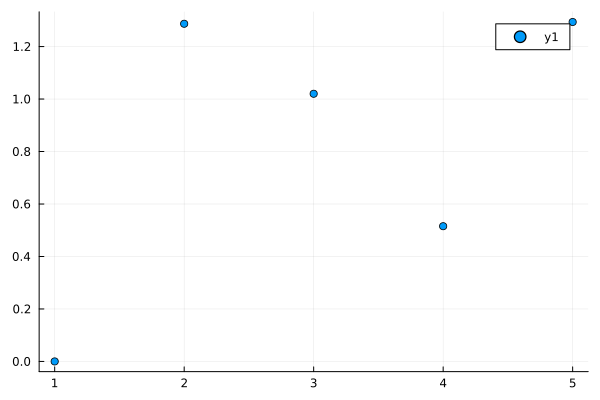

In [12]:
n_Fourier = rfft(n.-1)
freqs_space = fftshift(fftfreq(J,1/dx))
#Plots.scatter(freqs_space,abs.(fftshift(n_Fourier)))
Plots.scatter(abs.(n_Fourier)[1:5])

Check the histograms for the initial positions and velocities.

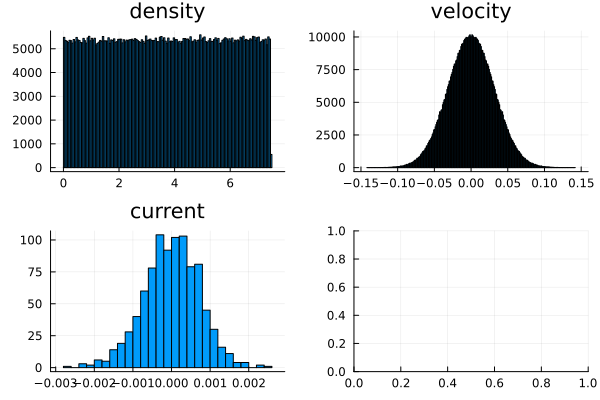

In [13]:
if !remote_server
    plot(layout=(2,2))
    histogram!(subplot=1,u[1:N], title = "density", legend = :false, bins = 300)
    histogram!(subplot=2,u[N+1:2*N], title = "velocity", legend = :false)

    histogram!(subplot=3,S, title = "current", legend = :false)
end

In [14]:
T = get_temperature_rel(u,N)

0.0009948918955690735

In [13]:
if phase_space_show
Plots.scatter(u[1:N],u[N+1:2N]
, thickness_scaling = 0.3
, markersize = 0.3
, title = "phase-space", legend =:false)
png(run_name * "initial-phase-space")
end

## TIME Evolution: 

Now we make the time evolution:

1. we define parameters and vectors where to upload data to study the time evolution: Kinetic Energy, Electric field Energy, Total Electric field, total velocity (momentum), total density, total charge current.

2. we save a vector with the particle phase space, this can be a lot of memory!

In [15]:
if nthreads() > 1
TS = zeros(J, nthreads())
p_RHSC = (N, J, L, dx, order, n, S, du, get_density!, get_current_rel_threads!, Interpolate_2, TS) ;
else
p_RHSC = (N, J, L, dx, order, n, S, du, get_density!, get_current_rel!, Interpolate_2) ;
end


(800000, 930, 7.455, 0.008016129032258065, 4, [1.0479046429050431, 1.0249960045634823, 1.0330346285481524, 1.0473843272124488, 1.022020874945613, 0.982762105554721, 0.9940118235642347, 1.0261636384781838, 1.0088541061253233, 0.9866616358250117  …  1.011590090509903, 1.0162968677601172, 1.0578804718605959, 1.0426921096883803, 1.0369686148337685, 1.0316571922668156, 1.0133328137112614, 0.9882611849085633, 0.9568090462759867, 1.0072758725277366], [-0.001183782304212958, -0.0010770508597496046, -0.00018548536238424462, 0.000781332859744183, 0.000366060335347397, 0.00023623856963744908, 0.0001157615668747107, 0.0006006141061790439, -0.0006585287018332933, -0.0006404917163760174  …  -0.0004335629640712348, -0.0012316013747560332, -0.0002147221789682233, -1.26569618113123e-5, 6.299475912754266e-5, 0.00029115107338371275, 0.0006947763244726713, 0.001542189309528342, 0.00028332006995245934, -0.0007529182550717957], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0

In [16]:
t = 0.0
j = 1

run_pars = Dict("run_name" => run_name, "par_grid" => par_grid, "par_evolv" => par_evolv, "p_Ini" => pars_f)

if full_outputs
    run_name = run_name * "_full"
elseif average_outputs
    run_name = run_name * "_ave"
end

file_name = "Results/"* run_name * ".jld2"
#rm(file_name)




save(file_name, run_pars)

if false # solo para testear
file = jldopen(file_name, "r+")
close(file)
end

if full_outputs
    field_name = "u"
    tiempo = @sprintf("%05d", j)
    jldopen(file_name, "a+") do file
        file[field_name * "/u_$(tiempo)"] = u;
    end
end

if average_outputs
    load_averages(file_name, j, par_grid, pars_f)
end


0.0009948918955690735

In [17]:

for k in 2:M
  RK4_Step!(RHSC_rel,u,t,dt,p_RHSC)
  global u = [make_periodic!(u[1:N],L); u[N+1:end]]
  #filter_constant!(u[2N+1:end])
  global t = t + dt
  if (k-1) % (M÷(M_g-1)) == 0
    local j = (k-1)÷(M÷(M_g-1))+1
    Energy_Ks, Energy_Es = get_energy_rel(u,(L, N, J))

    if average_outputs
      load_averages(file_name, j, par_grid, pars_f)
    end

    if full_outputs
        local tiempo = @sprintf("%05d", j)
        jldopen(file_name, "a+") do file
            file[field_name * "/u_$(tiempo)"] = u
      end
    end

    println("j = $j , t = $t, k = $k, nthreads = $(nthreads()), Energy = $(Energy_Ks + Energy_Es)")

    if animation
      par[j,:] = u[1:2N]
    end
  end
end

j = 2 , t = 0.005, k = 3, nthreads = 2, Energy = 0.003744402153073655


j = 3 , t = 0.01, k = 5, nthreads = 2, Energy = 0.003744402164811223


j = 4 , t = 0.015000000000000001, k = 7, nthreads = 2, Energy = 0.0037444021807366474


j = 5 , t = 0.02, k = 9, nthreads = 2, Energy = 0.0037444022007920704


j = 6 , t = 0.024999999999999998, k = 11, nthreads = 2, Energy = 0.0037444022249005227


j = 7 , t = 0.029999999999999995, k = 13, nthreads = 2, Energy = 0.0037444022529662716


j = 8 , t = 0.034999999999999996, k = 15, nthreads = 2, Energy = 0.0037444022848731984


j = 9 , t = 0.04, k = 17, nthreads = 2, Energy = 0.0037444023204893837


j = 10 , t = 0.045000000000000005, k = 19, nthreads = 2, Energy = 0.003744402359668801


j = 11 , t = 0.05000000000000001, k = 21, nthreads = 2, Energy = 0.0037444024022521213


j = 12 , t = 0.055000000000000014, k = 23, nthreads = 2, Energy = 0.003744402448070232


j = 13 , t = 0.06000000000000002, k = 25, nthreads = 2, Energy = 0.003744402496944303


j = 14 , t = 0.06500000000000002, k = 27, nthreads = 2, Energy = 0.0037444025486860085


j = 15 , t = 0.07000000000000002, k = 29, nthreads = 2, Energy = 0.0037444026030958124


j = 16 , t = 0.07500000000000002, k = 31, nthreads = 2, Energy = 0.0037444026599640925


j = 17 , t = 0.08000000000000003, k = 33, nthreads = 2, Energy = 0.003744402719068375


j = 18 , t = 0.08500000000000003, k = 35, nthreads = 2, Energy = 0.003744402780172157


j = 19 , t = 0.09000000000000004, k = 37, nthreads = 2, Energy = 0.003744402843027727


j = 20 , t = 0.09500000000000004, k = 39, nthreads = 2, Energy = 0.003744402907375467


j = 21 , t = 0.10000000000000005, k = 41, nthreads = 2, Energy = 0.0037444029729472392


j = 22 , t = 0.10500000000000005, k = 43, nthreads = 2, Energy = 0.0037444030394649472


j = 23 , t = 0.11000000000000006, k = 45, nthreads = 2, Energy = 0.0037444031066414664


j = 24 , t = 0.11500000000000006, k = 47, nthreads = 2, Energy = 0.003744403174185017


j = 25 , t = 0.12000000000000006, k = 49, nthreads = 2, Energy = 0.0037444032418058716


j = 26 , t = 0.12500000000000006, k = 51, nthreads = 2, Energy = 0.0037444033092204005


j = 27 , t = 0.13000000000000006, k = 53, nthreads = 2, Energy = 0.003744403376154985


j = 28 , t = 0.13500000000000006, k = 55, nthreads = 2, Energy = 0.003744403442348721


j = 29 , t = 0.14000000000000007, k = 57, nthreads = 2, Energy = 0.0037444035075552425


j = 30 , t = 0.14500000000000007, k = 59, nthreads = 2, Energy = 0.003744403571543104


j = 31 , t = 0.15000000000000008, k = 61, nthreads = 2, Energy = 0.0037444036340973813


j = 32 , t = 0.15500000000000008, k = 63, nthreads = 2, Energy = 0.003744403695017354


j = 33 , t = 0.1600000000000001, k = 65, nthreads = 2, Energy = 0.0037444037541200783


j = 34 , t = 0.1650000000000001, k = 67, nthreads = 2, Energy = 0.0037444038112405286


j = 35 , t = 0.1700000000000001, k = 69, nthreads = 2, Energy = 0.003744403866231389


j = 36 , t = 0.1750000000000001, k = 71, nthreads = 2, Energy = 0.0037444039189624685


j = 37 , t = 0.1800000000000001, k = 73, nthreads = 2, Energy = 0.0037444039693125732


j = 38 , t = 0.1850000000000001, k = 75, nthreads = 2, Energy = 0.0037444040171717404


j = 39 , t = 0.1900000000000001, k = 77, nthreads = 2, Energy = 0.0037444040624366247


j = 40 , t = 0.19500000000000012, k = 79, nthreads = 2, Energy = 0.003744404105013983


j = 41 , t = 0.20000000000000012, k = 81, nthreads = 2, Energy = 0.003744404144821935


j = 42 , t = 0.20500000000000013, k = 83, nthreads = 2, Energy = 0.003744404181793589


j = 43 , t = 0.21000000000000013, k = 85, nthreads = 2, Energy = 0.0037444042158792045


j = 44 , t = 0.21500000000000014, k = 87, nthreads = 2, Energy = 0.0037444042470458965


j = 45 , t = 0.22000000000000014, k = 89, nthreads = 2, Energy = 0.0037444042752814025


j = 46 , t = 0.22500000000000014, k = 91, nthreads = 2, Energy = 0.0037444043005945764


j = 47 , t = 0.23000000000000015, k = 93, nthreads = 2, Energy = 0.0037444043230165473


j = 48 , t = 0.23500000000000015, k = 95, nthreads = 2, Energy = 0.003744404342601329


j = 49 , t = 0.24000000000000016, k = 97, nthreads = 2, Energy = 0.003744404359426951


j = 50 , t = 0.24500000000000016, k = 99, nthreads = 2, Energy = 0.003744404373600144


j = 51 , t = 0.25000000000000017, k = 101, nthreads = 2, Energy = 0.0037444043852567616


j = 52 , t = 0.25500000000000017, k = 103, nthreads = 2, Energy = 0.003744404394564663


j = 53 , t = 0.2600000000000002, k = 105, nthreads = 2, Energy = 0.003744404401719669


j = 54 , t = 0.2650000000000002, k = 107, nthreads = 2, Energy = 0.0037444044069363056


j = 55 , t = 0.2700000000000002, k = 109, nthreads = 2, Energy = 0.0037444044104443437


j = 56 , t = 0.2750000000000002, k = 111, nthreads = 2, Energy = 0.0037444044124784544


j = 57 , t = 0.2800000000000002, k = 113, nthreads = 2, Energy = 0.00374440441327592


j = 58 , t = 0.2850000000000002, k = 115, nthreads = 2, Energy = 0.003744404413070728


j = 59 , t = 0.2900000000000002, k = 117, nthreads = 2, Energy = 0.0037444044120871632


j = 60 , t = 0.2950000000000002, k = 119, nthreads = 2, Energy = 0.003744404410536504


j = 61 , t = 0.3000000000000002, k = 121, nthreads = 2, Energy = 0.0037444044086119383


j = 62 , t = 0.3050000000000002, k = 123, nthreads = 2, Energy = 0.0037444044064862837


j = 63 , t = 0.3100000000000002, k = 125, nthreads = 2, Energy = 0.0037444044043054877


j = 64 , t = 0.3150000000000002, k = 127, nthreads = 2, Energy = 0.0037444044021885023


j = 65 , t = 0.32000000000000023, k = 129, nthreads = 2, Energy = 0.003744404400227494


j = 66 , t = 0.32500000000000023, k = 131, nthreads = 2, Energy = 0.0037444043984947973


j = 67 , t = 0.33000000000000024, k = 133, nthreads = 2, Energy = 0.0037444043970462


j = 68 , t = 0.33500000000000024, k = 135, nthreads = 2, Energy = 0.0037444043959184853


j = 69 , t = 0.34000000000000025, k = 137, nthreads = 2, Energy = 0.0037444043951276214


j = 70 , t = 0.34500000000000025, k = 139, nthreads = 2, Energy = 0.0037444043946657348


j = 71 , t = 0.35000000000000026, k = 141, nthreads = 2, Energy = 0.0037444043945014938


j = 72 , t = 0.35500000000000026, k = 143, nthreads = 2, Energy = 0.003744404394584247


j = 73 , t = 0.36000000000000026, k = 145, nthreads = 2, Energy = 0.003744404394845901


j = 74 , t = 0.36500000000000027, k = 147, nthreads = 2, Energy = 0.003744404395200159


j = 75 , t = 0.3700000000000003, k = 149, nthreads = 2, Energy = 0.0037444043955468117


j = 76 , t = 0.3750000000000003, k = 151, nthreads = 2, Energy = 0.0037444043957757605


j = 77 , t = 0.3800000000000003, k = 153, nthreads = 2, Energy = 0.0037444043957730023


j = 78 , t = 0.3850000000000003, k = 155, nthreads = 2, Energy = 0.0037444043954214705


j = 79 , t = 0.3900000000000003, k = 157, nthreads = 2, Energy = 0.003744404394603371


j = 80 , t = 0.3950000000000003, k = 159, nthreads = 2, Energy = 0.0037444043932032605


j = 81 , t = 0.4000000000000003, k = 161, nthreads = 2, Energy = 0.0037444043911069947


j = 82 , t = 0.4050000000000003, k = 163, nthreads = 2, Energy = 0.00374440438820188


j = 83 , t = 0.4100000000000003, k = 165, nthreads = 2, Energy = 0.0037444043843761947


j = 84 , t = 0.4150000000000003, k = 167, nthreads = 2, Energy = 0.003744404379521192


j = 85 , t = 0.4200000000000003, k = 169, nthreads = 2, Energy = 0.003744404373537185


j = 86 , t = 0.4250000000000003, k = 171, nthreads = 2, Energy = 0.0037444043663326667


j = 87 , t = 0.4300000000000003, k = 173, nthreads = 2, Energy = 0.0037444043578266067


j = 88 , t = 0.43500000000000033, k = 175, nthreads = 2, Energy = 0.0037444043479465464


j = 89 , t = 0.44000000000000034, k = 177, nthreads = 2, Energy = 0.0037444043366299585


j = 90 , t = 0.44500000000000034, k = 179, nthreads = 2, Energy = 0.003744404323825037


j = 91 , t = 0.45000000000000034, k = 181, nthreads = 2, Energy = 0.0037444043094975615


j = 92 , t = 0.45500000000000035, k = 183, nthreads = 2, Energy = 0.0037444042936338236


j = 93 , t = 0.46000000000000035, k = 185, nthreads = 2, Energy = 0.0037444042762457713


j = 94 , t = 0.46500000000000036, k = 187, nthreads = 2, Energy = 0.0037444042573723563


j = 95 , t = 0.47000000000000036, k = 189, nthreads = 2, Energy = 0.003744404237075985


j = 96 , t = 0.47500000000000037, k = 191, nthreads = 2, Energy = 0.0037444042154386806


j = 97 , t = 0.48000000000000037, k = 193, nthreads = 2, Energy = 0.0037444041925647417


j = 98 , t = 0.4850000000000004, k = 195, nthreads = 2, Energy = 0.003744404168583861


j = 99 , t = 0.4900000000000004, k = 197, nthreads = 2, Energy = 0.003744404143649087


j = 100 , t = 0.4950000000000004, k = 199, nthreads = 2, Energy = 0.003744404117927548


j = 101 , t = 0.5000000000000003, k = 201, nthreads = 2, Energy = 0.003744404091597441


j = 102 , t = 0.5050000000000002, k = 203, nthreads = 2, Energy = 0.0037444040648387487


j = 103 , t = 0.5100000000000001, k = 205, nthreads = 2, Energy = 0.0037444040378258234


j = 104 , t = 0.515, k = 207, nthreads = 2, Energy = 0.003744404010723999


j = 105 , t = 0.5199999999999999, k = 209, nthreads = 2, Energy = 0.003744403983685914


j = 106 , t = 0.5249999999999998, k = 211, nthreads = 2, Energy = 0.003744403956850956


j = 107 , t = 0.5299999999999997, k = 213, nthreads = 2, Energy = 0.003744403930348372


j = 108 , t = 0.5349999999999996, k = 215, nthreads = 2, Energy = 0.0037444039042999573


j = 109 , t = 0.5399999999999995, k = 217, nthreads = 2, Energy = 0.0037444038788185694


j = 110 , t = 0.5449999999999994, k = 219, nthreads = 2, Energy = 0.0037444038540046087


j = 111 , t = 0.5499999999999993, k = 221, nthreads = 2, Energy = 0.0037444038299438496


j = 112 , t = 0.5549999999999992, k = 223, nthreads = 2, Energy = 0.003744403806704227


j = 113 , t = 0.559999999999999, k = 225, nthreads = 2, Energy = 0.0037444037843351896


j = 114 , t = 0.564999999999999, k = 227, nthreads = 2, Energy = 0.003744403762868868


j = 115 , t = 0.5699999999999988, k = 229, nthreads = 2, Energy = 0.0037444037423253343


j = 116 , t = 0.5749999999999987, k = 231, nthreads = 2, Energy = 0.003744403722717839


j = 117 , t = 0.5799999999999986, k = 233, nthreads = 2, Energy = 0.0037444037040543364


j = 118 , t = 0.5849999999999985, k = 235, nthreads = 2, Energy = 0.0037444036863361887


j = 119 , t = 0.5899999999999984, k = 237, nthreads = 2, Energy = 0.0037444036695585587


j = 120 , t = 0.5949999999999983, k = 239, nthreads = 2, Energy = 0.003744403653710862


j = 121 , t = 0.5999999999999982, k = 241, nthreads = 2, Energy = 0.0037444036387748935


j = 122 , t = 0.6049999999999981, k = 243, nthreads = 2, Energy = 0.0037444036247242496


j = 123 , t = 0.609999999999998, k = 245, nthreads = 2, Energy = 0.0037444036115269618


j = 124 , t = 0.6149999999999979, k = 247, nthreads = 2, Energy = 0.003744403599147444


j = 125 , t = 0.6199999999999978, k = 249, nthreads = 2, Energy = 0.0037444035875499005


j = 126 , t = 0.6249999999999977, k = 251, nthreads = 2, Energy = 0.003744403576700845


j = 127 , t = 0.6299999999999976, k = 253, nthreads = 2, Energy = 0.0037444035665684912


j = 128 , t = 0.6349999999999975, k = 255, nthreads = 2, Energy = 0.003744403557121572


j = 129 , t = 0.6399999999999973, k = 257, nthreads = 2, Energy = 0.0037444035483265104


j = 130 , t = 0.6449999999999972, k = 259, nthreads = 2, Energy = 0.0037444035401490634


j = 131 , t = 0.6499999999999971, k = 261, nthreads = 2, Energy = 0.003744403532553264


j = 132 , t = 0.654999999999997, k = 263, nthreads = 2, Energy = 0.003744403525505211


j = 133 , t = 0.6599999999999969, k = 265, nthreads = 2, Energy = 0.003744403518976395


j = 134 , t = 0.6649999999999968, k = 267, nthreads = 2, Energy = 0.0037444035129437793


j = 135 , t = 0.6699999999999967, k = 269, nthreads = 2, Energy = 0.0037444035073887403


j = 136 , t = 0.6749999999999966, k = 271, nthreads = 2, Energy = 0.003744403502296589


j = 137 , t = 0.6799999999999965, k = 273, nthreads = 2, Energy = 0.0037444034976494337


j = 138 , t = 0.6849999999999964, k = 275, nthreads = 2, Energy = 0.0037444034934218475


j = 139 , t = 0.6899999999999963, k = 277, nthreads = 2, Energy = 0.0037444034895830294


j = 140 , t = 0.6949999999999962, k = 279, nthreads = 2, Energy = 0.0037444034860976815


j = 141 , t = 0.6999999999999961, k = 281, nthreads = 2, Energy = 0.0037444034829257774


j = 142 , t = 0.704999999999996, k = 283, nthreads = 2, Energy = 0.003744403480022248


j = 143 , t = 0.7099999999999959, k = 285, nthreads = 2, Energy = 0.003744403477337227


j = 144 , t = 0.7149999999999958, k = 287, nthreads = 2, Energy = 0.003744403474813431


j = 145 , t = 0.7199999999999956, k = 289, nthreads = 2, Energy = 0.0037444034723830132


j = 146 , t = 0.7249999999999955, k = 291, nthreads = 2, Energy = 0.0037444034699692197


j = 147 , t = 0.7299999999999954, k = 293, nthreads = 2, Energy = 0.003744403467484781


j = 148 , t = 0.7349999999999953, k = 295, nthreads = 2, Energy = 0.0037444034648373833


j = 149 , t = 0.7399999999999952, k = 297, nthreads = 2, Energy = 0.0037444034619296598


j = 150 , t = 0.7449999999999951, k = 299, nthreads = 2, Energy = 0.0037444034586669307


j = 151 , t = 0.749999999999995, k = 301, nthreads = 2, Energy = 0.003744403454965916


j = 152 , t = 0.7549999999999949, k = 303, nthreads = 2, Energy = 0.0037444034507574954


j = 153 , t = 0.7599999999999948, k = 305, nthreads = 2, Energy = 0.003744403445988592


j = 154 , t = 0.7649999999999947, k = 307, nthreads = 2, Energy = 0.0037444034406228966


j = 155 , t = 0.7699999999999946, k = 309, nthreads = 2, Energy = 0.003744403434641611


j = 156 , t = 0.7749999999999945, k = 311, nthreads = 2, Energy = 0.0037444034280403123


j = 157 , t = 0.7799999999999944, k = 313, nthreads = 2, Energy = 0.0037444034208314217


j = 158 , t = 0.7849999999999943, k = 315, nthreads = 2, Energy = 0.0037444034130413987


j = 159 , t = 0.7899999999999942, k = 317, nthreads = 2, Energy = 0.0037444034047149346


j = 160 , t = 0.794999999999994, k = 319, nthreads = 2, Energy = 0.0037444033959134954


j = 161 , t = 0.7999999999999939, k = 321, nthreads = 2, Energy = 0.0037444033867120234


j = 162 , t = 0.8049999999999938, k = 323, nthreads = 2, Energy = 0.003744403377191821


j = 163 , t = 0.8099999999999937, k = 325, nthreads = 2, Energy = 0.0037444033674359513


j = 164 , t = 0.8149999999999936, k = 327, nthreads = 2, Energy = 0.00374440335752267


j = 165 , t = 0.8199999999999935, k = 329, nthreads = 2, Energy = 0.003744403347519011


j = 166 , t = 0.8249999999999934, k = 331, nthreads = 2, Energy = 0.003744403337479475


j = 167 , t = 0.8299999999999933, k = 333, nthreads = 2, Energy = 0.003744403327444059


j = 168 , t = 0.8349999999999932, k = 335, nthreads = 2, Energy = 0.0037444033174349575


j = 169 , t = 0.8399999999999931, k = 337, nthreads = 2, Energy = 0.0037444033074524423


j = 170 , t = 0.844999999999993, k = 339, nthreads = 2, Energy = 0.003744403297474422


j = 171 , t = 0.8499999999999929, k = 341, nthreads = 2, Energy = 0.003744403287464364


j = 172 , t = 0.8549999999999928, k = 343, nthreads = 2, Energy = 0.0037444032773727453


j = 173 , t = 0.8599999999999927, k = 345, nthreads = 2, Energy = 0.0037444032671462863


j = 174 , t = 0.8649999999999926, k = 347, nthreads = 2, Energy = 0.0037444032567293764


j = 175 , t = 0.8699999999999924, k = 349, nthreads = 2, Energy = 0.0037444032460678084


j = 176 , t = 0.8749999999999923, k = 351, nthreads = 2, Energy = 0.0037444032351075887


j = 177 , t = 0.8799999999999922, k = 353, nthreads = 2, Energy = 0.0037444032237991154


j = 178 , t = 0.8849999999999921, k = 355, nthreads = 2, Energy = 0.0037444032121022996


j = 179 , t = 0.889999999999992, k = 357, nthreads = 2, Energy = 0.0037444031999847127


j = 180 , t = 0.8949999999999919, k = 359, nthreads = 2, Energy = 0.003744403187422624


j = 181 , t = 0.8999999999999918, k = 361, nthreads = 2, Energy = 0.0037444031744028107


j = 182 , t = 0.9049999999999917, k = 363, nthreads = 2, Energy = 0.003744403160919146


j = 183 , t = 0.9099999999999916, k = 365, nthreads = 2, Energy = 0.003744403146966481


j = 184 , t = 0.9149999999999915, k = 367, nthreads = 2, Energy = 0.0037444031325384332


j = 185 , t = 0.9199999999999914, k = 369, nthreads = 2, Energy = 0.0037444031176234616


j = 186 , t = 0.9249999999999913, k = 371, nthreads = 2, Energy = 0.003744403102205098


j = 187 , t = 0.9299999999999912, k = 373, nthreads = 2, Energy = 0.0037444030862607922


j = 188 , t = 0.9349999999999911, k = 375, nthreads = 2, Energy = 0.0037444030697611373


j = 189 , t = 0.939999999999991, k = 377, nthreads = 2, Energy = 0.0037444030526740113


j = 190 , t = 0.9449999999999908, k = 379, nthreads = 2, Energy = 0.0037444030349670786


j = 191 , t = 0.9499999999999907, k = 381, nthreads = 2, Energy = 0.0037444030166096554


j = 192 , t = 0.9549999999999906, k = 383, nthreads = 2, Energy = 0.003744402997571753


j = 193 , t = 0.9599999999999905, k = 385, nthreads = 2, Energy = 0.00374440297782615


j = 194 , t = 0.9649999999999904, k = 387, nthreads = 2, Energy = 0.0037444029573526407


j = 195 , t = 0.9699999999999903, k = 389, nthreads = 2, Energy = 0.003744402936140367


j = 196 , t = 0.9749999999999902, k = 391, nthreads = 2, Energy = 0.003744402914193338


j = 197 , t = 0.9799999999999901, k = 393, nthreads = 2, Energy = 0.0037444028915318496


j = 198 , t = 0.98499999999999, k = 395, nthreads = 2, Energy = 0.0037444028681932794


j = 199 , t = 0.9899999999999899, k = 397, nthreads = 2, Energy = 0.0037444028442309963


j = 200 , t = 0.9949999999999898, k = 399, nthreads = 2, Energy = 0.003744402819719198


j = 201 , t = 0.9999999999999897, k = 401, nthreads = 2, Energy = 0.003744402794752388


j = 202 , t = 1.0049999999999897, k = 403, nthreads = 2, Energy = 0.003744402769442398


j = 203 , t = 1.0099999999999896, k = 405, nthreads = 2, Energy = 0.003744402743914687


j = 204 , t = 1.0149999999999895, k = 407, nthreads = 2, Energy = 0.003744402718304292


j = 205 , t = 1.0199999999999894, k = 409, nthreads = 2, Energy = 0.0037444026927516577


j = 206 , t = 1.0249999999999893, k = 411, nthreads = 2, Energy = 0.003744402667396636


j = 207 , t = 1.0299999999999891, k = 413, nthreads = 2, Energy = 0.0037444026423723085


j = 208 , t = 1.034999999999989, k = 415, nthreads = 2, Energy = 0.0037444026178038857


j = 209 , t = 1.039999999999989, k = 417, nthreads = 2, Energy = 0.003744402593806703


j = 210 , t = 1.0449999999999888, k = 419, nthreads = 2, Energy = 0.0037444025704868387


j = 211 , t = 1.0499999999999887, k = 421, nthreads = 2, Energy = 0.003744402547941508


j = 212 , t = 1.0549999999999886, k = 423, nthreads = 2, Energy = 0.0037444025262537727


j = 213 , t = 1.0599999999999885, k = 425, nthreads = 2, Energy = 0.003744402505487552


j = 214 , t = 1.0649999999999884, k = 427, nthreads = 2, Energy = 0.0037444024856839245


j = 215 , t = 1.0699999999999883, k = 429, nthreads = 2, Energy = 0.0037444024668543095


j = 216 , t = 1.0749999999999882, k = 431, nthreads = 2, Energy = 0.003744402448978942


j = 217 , t = 1.079999999999988, k = 433, nthreads = 2, Energy = 0.0037444024320070477


j = 218 , t = 1.084999999999988, k = 435, nthreads = 2, Energy = 0.003744402415856394


j = 219 , t = 1.0899999999999879, k = 437, nthreads = 2, Energy = 0.0037444024004180277


j = 220 , t = 1.0949999999999878, k = 439, nthreads = 2, Energy = 0.0037444023855645755


j = 221 , t = 1.0999999999999877, k = 441, nthreads = 2, Energy = 0.0037444023711562862


j = 222 , t = 1.1049999999999875, k = 443, nthreads = 2, Energy = 0.003744402357050005


j = 223 , t = 1.1099999999999874, k = 445, nthreads = 2, Energy = 0.0037444023431058644


j = 224 , t = 1.1149999999999873, k = 447, nthreads = 2, Energy = 0.0037444023291902206


j = 225 , t = 1.1199999999999872, k = 449, nthreads = 2, Energy = 0.003744402315183771


j = 226 , t = 1.1249999999999871, k = 451, nthreads = 2, Energy = 0.0037444023009860477


j = 227 , t = 1.129999999999987, k = 453, nthreads = 2, Energy = 0.0037444022865199167


j = 228 , t = 1.134999999999987, k = 455, nthreads = 2, Energy = 0.0037444022717399894


j = 229 , t = 1.1399999999999868, k = 457, nthreads = 2, Energy = 0.003744402256629383


j = 230 , t = 1.1449999999999867, k = 459, nthreads = 2, Energy = 0.0037444022411949897


j = 231 , t = 1.1499999999999866, k = 461, nthreads = 2, Energy = 0.003744402225459643


j = 232 , t = 1.1549999999999865, k = 463, nthreads = 2, Energy = 0.003744402209458895


j = 233 , t = 1.1599999999999864, k = 465, nthreads = 2, Energy = 0.003744402193230914


j = 234 , t = 1.1649999999999863, k = 467, nthreads = 2, Energy = 0.003744402176815579


j = 235 , t = 1.1699999999999862, k = 469, nthreads = 2, Energy = 0.003744402160250616


j = 236 , t = 1.174999999999986, k = 471, nthreads = 2, Energy = 0.003744402143572462


j = 237 , t = 1.179999999999986, k = 473, nthreads = 2, Energy = 0.0037444021268147293


j = 238 , t = 1.1849999999999858, k = 475, nthreads = 2, Energy = 0.0037444021100080252


j = 239 , t = 1.1899999999999857, k = 477, nthreads = 2, Energy = 0.0037444020931834575


j = 240 , t = 1.1949999999999856, k = 479, nthreads = 2, Energy = 0.0037444020763804423


j = 241 , t = 1.1999999999999855, k = 481, nthreads = 2, Energy = 0.0037444020596460125


j = 242 , t = 1.2049999999999854, k = 483, nthreads = 2, Energy = 0.003744402043035208


j = 243 , t = 1.2099999999999853, k = 485, nthreads = 2, Energy = 0.0037444020266107266


j = 244 , t = 1.2149999999999852, k = 487, nthreads = 2, Energy = 0.00374440201044341


j = 245 , t = 1.219999999999985, k = 489, nthreads = 2, Energy = 0.0037444019946150085


j = 246 , t = 1.224999999999985, k = 491, nthreads = 2, Energy = 0.003744401979216479


j = 247 , t = 1.2299999999999849, k = 493, nthreads = 2, Energy = 0.0037444019643433427


j = 248 , t = 1.2349999999999848, k = 495, nthreads = 2, Energy = 0.0037444019500905467


j = 249 , t = 1.2399999999999847, k = 497, nthreads = 2, Energy = 0.003744401936549911


j = 250 , t = 1.2449999999999846, k = 499, nthreads = 2, Energy = 0.003744401923806511


j = 251 , t = 1.2499999999999845, k = 501, nthreads = 2, Energy = 0.0037444019119345787


j = 252 , t = 1.2549999999999844, k = 503, nthreads = 2, Energy = 0.003744401900991841


j = 253 , t = 1.2599999999999842, k = 505, nthreads = 2, Energy = 0.003744401891016241


j = 254 , t = 1.2649999999999841, k = 507, nthreads = 2, Energy = 0.0037444018820224404


j = 255 , t = 1.269999999999984, k = 509, nthreads = 2, Energy = 0.0037444018740071306


j = 256 , t = 1.274999999999984, k = 511, nthreads = 2, Energy = 0.003744401866950683


j = 257 , t = 1.2799999999999838, k = 513, nthreads = 2, Energy = 0.003744401860815608


j = 258 , t = 1.2849999999999837, k = 515, nthreads = 2, Energy = 0.0037444018555439365


j = 259 , t = 1.2899999999999836, k = 517, nthreads = 2, Energy = 0.0037444018510596473


j = 260 , t = 1.2949999999999835, k = 519, nthreads = 2, Energy = 0.003744401847272993


j = 261 , t = 1.2999999999999834, k = 521, nthreads = 2, Energy = 0.0037444018440806527


j = 262 , t = 1.3049999999999833, k = 523, nthreads = 2, Energy = 0.0037444018413704348


j = 263 , t = 1.3099999999999832, k = 525, nthreads = 2, Energy = 0.00374440183902207


j = 264 , t = 1.314999999999983, k = 527, nthreads = 2, Energy = 0.00374440183691134


j = 265 , t = 1.319999999999983, k = 529, nthreads = 2, Energy = 0.0037444018349174547


j = 266 , t = 1.3249999999999829, k = 531, nthreads = 2, Energy = 0.0037444018329285083


j = 267 , t = 1.3299999999999828, k = 533, nthreads = 2, Energy = 0.0037444018308460383


j = 268 , t = 1.3349999999999826, k = 535, nthreads = 2, Energy = 0.0037444018285875294


j = 269 , t = 1.3399999999999825, k = 537, nthreads = 2, Energy = 0.0037444018260888714


j = 270 , t = 1.3449999999999824, k = 539, nthreads = 2, Energy = 0.0037444018233018443


j = 271 , t = 1.3499999999999823, k = 541, nthreads = 2, Energy = 0.0037444018201935668


j = 272 , t = 1.3549999999999822, k = 543, nthreads = 2, Energy = 0.003744401816745345


j = 273 , t = 1.3599999999999821, k = 545, nthreads = 2, Energy = 0.0037444018129512992


j = 274 , t = 1.364999999999982, k = 547, nthreads = 2, Energy = 0.003744401808819273


j = 275 , t = 1.369999999999982, k = 549, nthreads = 2, Energy = 0.003744401804368261


j = 276 , t = 1.3749999999999818, k = 551, nthreads = 2, Energy = 0.003744401799632329


j = 277 , t = 1.3799999999999817, k = 553, nthreads = 2, Energy = 0.0037444017946640096


j = 278 , t = 1.3849999999999816, k = 555, nthreads = 2, Energy = 0.003744401789533275


j = 279 , t = 1.3899999999999815, k = 557, nthreads = 2, Energy = 0.003744401784322227


j = 280 , t = 1.3949999999999814, k = 559, nthreads = 2, Energy = 0.003744401779117984


j = 281 , t = 1.3999999999999813, k = 561, nthreads = 2, Energy = 0.0037444017740092374


j = 282 , t = 1.4049999999999812, k = 563, nthreads = 2, Energy = 0.00374440176908201


j = 283 , t = 1.409999999999981, k = 565, nthreads = 2, Energy = 0.003744401764426404


j = 284 , t = 1.414999999999981, k = 567, nthreads = 2, Energy = 0.0037444017601401163


j = 285 , t = 1.4199999999999808, k = 569, nthreads = 2, Energy = 0.003744401756330964


j = 286 , t = 1.4249999999999807, k = 571, nthreads = 2, Energy = 0.003744401753112249


j = 287 , t = 1.4299999999999806, k = 573, nthreads = 2, Energy = 0.0037444017505963347


j = 288 , t = 1.4349999999999805, k = 575, nthreads = 2, Energy = 0.0037444017488895134


j = 289 , t = 1.4399999999999804, k = 577, nthreads = 2, Energy = 0.0037444017480879584


j = 290 , t = 1.4449999999999803, k = 579, nthreads = 2, Energy = 0.003744401748271578


j = 291 , t = 1.4499999999999802, k = 581, nthreads = 2, Energy = 0.0037444017495026957


j = 292 , t = 1.45499999999998, k = 583, nthreads = 2, Energy = 0.0037444017518202077


j = 293 , t = 1.45999999999998, k = 585, nthreads = 2, Energy = 0.0037444017552361584


j = 294 , t = 1.4649999999999799, k = 587, nthreads = 2, Energy = 0.0037444017597347795


j = 295 , t = 1.4699999999999798, k = 589, nthreads = 2, Energy = 0.003744401765276302


j = 296 , t = 1.4749999999999797, k = 591, nthreads = 2, Energy = 0.003744401771794489


j = 297 , t = 1.4799999999999796, k = 593, nthreads = 2, Energy = 0.003744401779199013


j = 298 , t = 1.4849999999999794, k = 595, nthreads = 2, Energy = 0.0037444017873812744


j = 299 , t = 1.4899999999999793, k = 597, nthreads = 2, Energy = 0.003744401796219425


j = 300 , t = 1.4949999999999792, k = 599, nthreads = 2, Energy = 0.0037444018055839737


j = 301 , t = 1.4999999999999791, k = 601, nthreads = 2, Energy = 0.0037444018153388386


j = 302 , t = 1.504999999999979, k = 603, nthreads = 2, Energy = 0.00374440182534456


j = 303 , t = 1.509999999999979, k = 605, nthreads = 2, Energy = 0.0037444018354608633


j = 304 , t = 1.5149999999999788, k = 607, nthreads = 2, Energy = 0.0037444018455468657


j = 305 , t = 1.5199999999999787, k = 609, nthreads = 2, Energy = 0.0037444018554634168


j = 306 , t = 1.5249999999999786, k = 611, nthreads = 2, Energy = 0.003744401865075003


j = 307 , t = 1.5299999999999785, k = 613, nthreads = 2, Energy = 0.00374440187425126


j = 308 , t = 1.5349999999999784, k = 615, nthreads = 2, Energy = 0.0037444018828640636


j = 309 , t = 1.5399999999999783, k = 617, nthreads = 2, Energy = 0.0037444018907822093


j = 310 , t = 1.5449999999999782, k = 619, nthreads = 2, Energy = 0.0037444018978644933


j = 311 , t = 1.549999999999978, k = 621, nthreads = 2, Energy = 0.003744401903959858


j = 312 , t = 1.554999999999978, k = 623, nthreads = 2, Energy = 0.0037444019089137017


j = 313 , t = 1.5599999999999778, k = 625, nthreads = 2, Energy = 0.003744401912571434


j = 314 , t = 1.5649999999999777, k = 627, nthreads = 2, Energy = 0.0037444019147853326


j = 315 , t = 1.5699999999999776, k = 629, nthreads = 2, Energy = 0.003744401915423491


j = 316 , t = 1.5749999999999775, k = 631, nthreads = 2, Energy = 0.0037444019143842524


j = 317 , t = 1.5799999999999774, k = 633, nthreads = 2, Energy = 0.0037444019116010287


j = 318 , t = 1.5849999999999773, k = 635, nthreads = 2, Energy = 0.0037444019070486056


j = 319 , t = 1.5899999999999772, k = 637, nthreads = 2, Energy = 0.0037444019007432014


j = 320 , t = 1.594999999999977, k = 639, nthreads = 2, Energy = 0.0037444018927469476


j = 321 , t = 1.599999999999977, k = 641, nthreads = 2, Energy = 0.0037444018831723227


j = 322 , t = 1.604999999999977, k = 643, nthreads = 2, Energy = 0.00374440187219037


j = 323 , t = 1.6099999999999768, k = 645, nthreads = 2, Energy = 0.0037444018600262126


j = 324 , t = 1.6149999999999767, k = 647, nthreads = 2, Energy = 0.003744401846949682


j = 325 , t = 1.6199999999999766, k = 649, nthreads = 2, Energy = 0.0037444018332648816


j = 326 , t = 1.6249999999999765, k = 651, nthreads = 2, Energy = 0.0037444018193039824


j = 327 , t = 1.6299999999999764, k = 653, nthreads = 2, Energy = 0.0037444018054151188


j = 328 , t = 1.6349999999999763, k = 655, nthreads = 2, Energy = 0.003744401791948633


j = 329 , t = 1.6399999999999761, k = 657, nthreads = 2, Energy = 0.0037444017792413954


j = 330 , t = 1.644999999999976, k = 659, nthreads = 2, Energy = 0.0037444017676054662


j = 331 , t = 1.649999999999976, k = 661, nthreads = 2, Energy = 0.0037444017573150883


j = 332 , t = 1.6549999999999758, k = 663, nthreads = 2, Energy = 0.0037444017485950675


j = 333 , t = 1.6599999999999757, k = 665, nthreads = 2, Energy = 0.003744401741616448


j = 334 , t = 1.6649999999999756, k = 667, nthreads = 2, Energy = 0.0037444017364923633


j = 335 , t = 1.6699999999999755, k = 669, nthreads = 2, Energy = 0.003744401733281705


j = 336 , t = 1.6749999999999754, k = 671, nthreads = 2, Energy = 0.0037444017319917364


j = 337 , t = 1.6799999999999753, k = 673, nthreads = 2, Energy = 0.0037444017325890997


j = 338 , t = 1.6849999999999752, k = 675, nthreads = 2, Energy = 0.003744401735009516


j = 339 , t = 1.689999999999975, k = 677, nthreads = 2, Energy = 0.003744401739165832


j = 340 , t = 1.694999999999975, k = 679, nthreads = 2, Energy = 0.0037444017449548414


j = 341 , t = 1.6999999999999749, k = 681, nthreads = 2, Energy = 0.003744401752267613


j = 342 , t = 1.7049999999999748, k = 683, nthreads = 2, Energy = 0.003744401760993991


j = 343 , t = 1.7099999999999747, k = 685, nthreads = 2, Energy = 0.0037444017710237384


j = 344 , t = 1.7149999999999745, k = 687, nthreads = 2, Energy = 0.0037444017822474015


j = 345 , t = 1.7199999999999744, k = 689, nthreads = 2, Energy = 0.003744401794562306


j = 346 , t = 1.7249999999999743, k = 691, nthreads = 2, Energy = 0.00374440180787701


j = 347 , t = 1.7299999999999742, k = 693, nthreads = 2, Energy = 0.0037444018221100563


j = 348 , t = 1.7349999999999741, k = 695, nthreads = 2, Energy = 0.00374440183718767


j = 349 , t = 1.739999999999974, k = 697, nthreads = 2, Energy = 0.0037444018530412237


j = 350 , t = 1.744999999999974, k = 699, nthreads = 2, Energy = 0.003744401869605938


j = 351 , t = 1.7499999999999738, k = 701, nthreads = 2, Energy = 0.003744401886819161


j = 352 , t = 1.7549999999999737, k = 703, nthreads = 2, Energy = 0.003744401904617799


j = 353 , t = 1.7599999999999736, k = 705, nthreads = 2, Energy = 0.00374440192293793


j = 354 , t = 1.7649999999999735, k = 707, nthreads = 2, Energy = 0.0037444019417081555


j = 355 , t = 1.7699999999999734, k = 709, nthreads = 2, Energy = 0.003744401960850286


j = 356 , t = 1.7749999999999733, k = 711, nthreads = 2, Energy = 0.0037444019802780437


j = 357 , t = 1.7799999999999732, k = 713, nthreads = 2, Energy = 0.003744401999905237


j = 358 , t = 1.784999999999973, k = 715, nthreads = 2, Energy = 0.0037444020196491837


j = 359 , t = 1.789999999999973, k = 717, nthreads = 2, Energy = 0.0037444020394353022


j = 360 , t = 1.7949999999999728, k = 719, nthreads = 2, Energy = 0.003744402059196328


j = 361 , t = 1.7999999999999727, k = 721, nthreads = 2, Energy = 0.003744402078873371


j = 362 , t = 1.8049999999999726, k = 723, nthreads = 2, Energy = 0.0037444020984121694


j = 363 , t = 1.8099999999999725, k = 725, nthreads = 2, Energy = 0.003744402117763435


j = 364 , t = 1.8149999999999724, k = 727, nthreads = 2, Energy = 0.003744402136875858


j = 365 , t = 1.8199999999999723, k = 729, nthreads = 2, Energy = 0.0037444021556964167


j = 366 , t = 1.8249999999999722, k = 731, nthreads = 2, Energy = 0.0037444021741607084


j = 367 , t = 1.829999999999972, k = 733, nthreads = 2, Energy = 0.0037444021921928697


j = 368 , t = 1.834999999999972, k = 735, nthreads = 2, Energy = 0.0037444022097016818


j = 369 , t = 1.8399999999999719, k = 737, nthreads = 2, Energy = 0.0037444022265850922


j = 370 , t = 1.8449999999999718, k = 739, nthreads = 2, Energy = 0.0037444022427330762


j = 371 , t = 1.8499999999999717, k = 741, nthreads = 2, Energy = 0.003744402258027365


j = 372 , t = 1.8549999999999716, k = 743, nthreads = 2, Energy = 0.003744402272348409


j = 373 , t = 1.8599999999999715, k = 745, nthreads = 2, Energy = 0.003744402285580632


j = 374 , t = 1.8649999999999713, k = 747, nthreads = 2, Energy = 0.003744402297619773


j = 375 , t = 1.8699999999999712, k = 749, nthreads = 2, Energy = 0.003744402308380144


j = 376 , t = 1.8749999999999711, k = 751, nthreads = 2, Energy = 0.003744402317793958


j = 377 , t = 1.879999999999971, k = 753, nthreads = 2, Energy = 0.0037444023258114993


j = 378 , t = 1.884999999999971, k = 755, nthreads = 2, Energy = 0.003744402332404129


j = 379 , t = 1.8899999999999708, k = 757, nthreads = 2, Energy = 0.0037444023375645327


j = 380 , t = 1.8949999999999707, k = 759, nthreads = 2, Energy = 0.0037444023412981473


j = 381 , t = 1.8999999999999706, k = 761, nthreads = 2, Energy = 0.003744402343621868


j = 382 , t = 1.9049999999999705, k = 763, nthreads = 2, Energy = 0.003744402344558843


j = 383 , t = 1.9099999999999704, k = 765, nthreads = 2, Energy = 0.0037444023441359363


j = 384 , t = 1.9149999999999703, k = 767, nthreads = 2, Energy = 0.003744402342380823


j = 385 , t = 1.9199999999999702, k = 769, nthreads = 2, Energy = 0.0037444023393246114


j = 386 , t = 1.92499999999997, k = 771, nthreads = 2, Energy = 0.0037444023350052436


j = 387 , t = 1.92999999999997, k = 773, nthreads = 2, Energy = 0.003744402329467723


j = 388 , t = 1.9349999999999699, k = 775, nthreads = 2, Energy = 0.003744402322761767


j = 389 , t = 1.9399999999999697, k = 777, nthreads = 2, Energy = 0.003744402314947337


j = 390 , t = 1.9449999999999696, k = 779, nthreads = 2, Energy = 0.0037444023060985215


j = 391 , t = 1.9499999999999695, k = 781, nthreads = 2, Energy = 0.003744402296304484


j = 392 , t = 1.9549999999999694, k = 783, nthreads = 2, Energy = 0.0037444022856694156


j = 393 , t = 1.9599999999999693, k = 785, nthreads = 2, Energy = 0.0037444022743132964


j = 394 , t = 1.9649999999999692, k = 787, nthreads = 2, Energy = 0.003744402262373956


j = 395 , t = 1.969999999999969, k = 789, nthreads = 2, Energy = 0.0037444022500092815


j = 396 , t = 1.974999999999969, k = 791, nthreads = 2, Energy = 0.0037444022373959536


j = 397 , t = 1.979999999999969, k = 793, nthreads = 2, Energy = 0.0037444022247242878


j = 398 , t = 1.9849999999999688, k = 795, nthreads = 2, Energy = 0.0037444022121905663


j = 399 , t = 1.9899999999999687, k = 797, nthreads = 2, Energy = 0.0037444021999923603


j = 400 , t = 1.9949999999999686, k = 799, nthreads = 2, Energy = 0.0037444021883236167


j = 401 , t = 1.9999999999999685, k = 801, nthreads = 2, Energy = 0.003744402177370324


j = 402 , t = 2.0049999999999684, k = 803, nthreads = 2, Energy = 0.0037444021673097077


j = 403 , t = 2.0099999999999683, k = 805, nthreads = 2, Energy = 0.0037444021583057214


j = 404 , t = 2.014999999999968, k = 807, nthreads = 2, Energy = 0.00374440215050731


j = 405 , t = 2.019999999999968, k = 809, nthreads = 2, Energy = 0.0037444021440476093


j = 406 , t = 2.024999999999968, k = 811, nthreads = 2, Energy = 0.003744402139041103


j = 407 , t = 2.029999999999968, k = 813, nthreads = 2, Energy = 0.0037444021355851507


j = 408 , t = 2.0349999999999677, k = 815, nthreads = 2, Energy = 0.003744402133758784


j = 409 , t = 2.0399999999999676, k = 817, nthreads = 2, Energy = 0.003744402133619953


j = 410 , t = 2.0449999999999675, k = 819, nthreads = 2, Energy = 0.0037444021352016723


j = 411 , t = 2.0499999999999674, k = 821, nthreads = 2, Energy = 0.0037444021385079572


j = 412 , t = 2.0549999999999673, k = 823, nthreads = 2, Energy = 0.0037444021435146515


j = 413 , t = 2.059999999999967, k = 825, nthreads = 2, Energy = 0.0037444021501665896


j = 414 , t = 2.064999999999967, k = 827, nthreads = 2, Energy = 0.0037444021583813002


j = 415 , t = 2.069999999999967, k = 829, nthreads = 2, Energy = 0.003744402168055049


j = 416 , t = 2.074999999999967, k = 831, nthreads = 2, Energy = 0.0037444021790723507


j = 417 , t = 2.0799999999999668, k = 833, nthreads = 2, Energy = 0.0037444021913090645


j = 418 , t = 2.0849999999999667, k = 835, nthreads = 2, Energy = 0.00374440220463625


j = 419 , t = 2.0899999999999666, k = 837, nthreads = 2, Energy = 0.0037444022189224405


j = 420 , t = 2.0949999999999664, k = 839, nthreads = 2, Energy = 0.0037444022340396613


j = 421 , t = 2.0999999999999663, k = 841, nthreads = 2, Energy = 0.0037444022498668702


j = 422 , t = 2.1049999999999662, k = 843, nthreads = 2, Energy = 0.0037444022662933975


j = 423 , t = 2.109999999999966, k = 845, nthreads = 2, Energy = 0.0037444022832200264


j = 424 , t = 2.114999999999966, k = 847, nthreads = 2, Energy = 0.0037444023005579717


j = 425 , t = 2.119999999999966, k = 849, nthreads = 2, Energy = 0.0037444023182294553


j = 426 , t = 2.124999999999966, k = 851, nthreads = 2, Energy = 0.0037444023361617867


j = 427 , t = 2.1299999999999657, k = 853, nthreads = 2, Energy = 0.0037444023542788064


j = 428 , t = 2.1349999999999656, k = 855, nthreads = 2, Energy = 0.0037444023724929353


j = 429 , t = 2.1399999999999655, k = 857, nthreads = 2, Energy = 0.0037444023907034635


j = 430 , t = 2.1449999999999654, k = 859, nthreads = 2, Energy = 0.003744402408795529


j = 431 , t = 2.1499999999999653, k = 861, nthreads = 2, Energy = 0.003744402426641443


j = 432 , t = 2.154999999999965, k = 863, nthreads = 2, Energy = 0.0037444024441066755


j = 433 , t = 2.159999999999965, k = 865, nthreads = 2, Energy = 0.003744402461057849


j = 434 , t = 2.164999999999965, k = 867, nthreads = 2, Energy = 0.0037444024773698173


j = 435 , t = 2.169999999999965, k = 869, nthreads = 2, Energy = 0.0037444024929281497


j = 436 , t = 2.1749999999999647, k = 871, nthreads = 2, Energy = 0.0037444025076370834


j = 437 , t = 2.1799999999999646, k = 873, nthreads = 2, Energy = 0.0037444025214281333


j = 438 , t = 2.1849999999999645, k = 875, nthreads = 2, Energy = 0.0037444025342670073


j = 439 , t = 2.1899999999999644, k = 877, nthreads = 2, Energy = 0.0037444025461561437


j = 440 , t = 2.1949999999999643, k = 879, nthreads = 2, Energy = 0.00374440255713641


j = 441 , t = 2.199999999999964, k = 881, nthreads = 2, Energy = 0.0037444025672833557


j = 442 , t = 2.204999999999964, k = 883, nthreads = 2, Energy = 0.0037444025767054555


j = 443 , t = 2.209999999999964, k = 885, nthreads = 2, Energy = 0.0037444025855395656


j = 444 , t = 2.214999999999964, k = 887, nthreads = 2, Energy = 0.003744402593944456


j = 445 , t = 2.219999999999964, k = 889, nthreads = 2, Energy = 0.003744402602094732


j = 446 , t = 2.2249999999999637, k = 891, nthreads = 2, Energy = 0.0037444026101725544


j = 447 , t = 2.2299999999999636, k = 893, nthreads = 2, Energy = 0.0037444026183583684


j = 448 , t = 2.2349999999999635, k = 895, nthreads = 2, Energy = 0.0037444026268247292


j = 449 , t = 2.2399999999999634, k = 897, nthreads = 2, Energy = 0.0037444026357318708


j = 450 , t = 2.2449999999999632, k = 899, nthreads = 2, Energy = 0.003744402645224929


j = 451 , t = 2.249999999999963, k = 901, nthreads = 2, Energy = 0.003744402655434241


j = 452 , t = 2.254999999999963, k = 903, nthreads = 2, Energy = 0.0037444026664766776


j = 453 , t = 2.259999999999963, k = 905, nthreads = 2, Energy = 0.003744402678450843


j = 454 , t = 2.264999999999963, k = 907, nthreads = 2, Energy = 0.0037444026914327873


j = 455 , t = 2.2699999999999627, k = 909, nthreads = 2, Energy = 0.0037444027054697473


j = 456 , t = 2.2749999999999626, k = 911, nthreads = 2, Energy = 0.0037444027205770047


j = 457 , t = 2.2799999999999625, k = 913, nthreads = 2, Energy = 0.0037444027367376734


j = 458 , t = 2.2849999999999624, k = 915, nthreads = 2, Energy = 0.0037444027539089426


j = 459 , t = 2.2899999999999623, k = 917, nthreads = 2, Energy = 0.003744402772022716


j = 460 , t = 2.294999999999962, k = 919, nthreads = 2, Energy = 0.003744402790992224


j = 461 , t = 2.299999999999962, k = 921, nthreads = 2, Energy = 0.0037444028107151976


j = 462 , t = 2.304999999999962, k = 923, nthreads = 2, Energy = 0.003744402831074685


j = 463 , t = 2.309999999999962, k = 925, nthreads = 2, Energy = 0.0037444028519388393


j = 464 , t = 2.3149999999999618, k = 927, nthreads = 2, Energy = 0.003744402873163907


j = 465 , t = 2.3199999999999616, k = 929, nthreads = 2, Energy = 0.003744402894595637


j = 466 , t = 2.3249999999999615, k = 931, nthreads = 2, Energy = 0.0037444029160688917


j = 467 , t = 2.3299999999999614, k = 933, nthreads = 2, Energy = 0.00374440293740941


j = 468 , t = 2.3349999999999613, k = 935, nthreads = 2, Energy = 0.003744402958439859


j = 469 , t = 2.3399999999999612, k = 937, nthreads = 2, Energy = 0.0037444029789897777


j = 470 , t = 2.344999999999961, k = 939, nthreads = 2, Energy = 0.003744402998898808


j = 471 , t = 2.349999999999961, k = 941, nthreads = 2, Energy = 0.0037444030180207905


j = 472 , t = 2.354999999999961, k = 943, nthreads = 2, Energy = 0.0037444030362295396


j = 473 , t = 2.359999999999961, k = 945, nthreads = 2, Energy = 0.0037444030534276762


j = 474 , t = 2.3649999999999607, k = 947, nthreads = 2, Energy = 0.003744403069553466


j = 475 , t = 2.3699999999999606, k = 949, nthreads = 2, Energy = 0.0037444030845767743


j = 476 , t = 2.3749999999999605, k = 951, nthreads = 2, Energy = 0.0037444030984968087


j = 477 , t = 2.3799999999999604, k = 953, nthreads = 2, Energy = 0.003744403111341637


j = 478 , t = 2.3849999999999603, k = 955, nthreads = 2, Energy = 0.0037444031231633223


j = 479 , t = 2.38999999999996, k = 957, nthreads = 2, Energy = 0.00374440313402716


j = 480 , t = 2.39499999999996, k = 959, nthreads = 2, Energy = 0.0037444031440065


j = 481 , t = 2.39999999999996, k = 961, nthreads = 2, Energy = 0.00374440315317617


j = 482 , t = 2.40499999999996, k = 963, nthreads = 2, Energy = 0.0037444031616099115


j = 483 , t = 2.4099999999999597, k = 965, nthreads = 2, Energy = 0.0037444031693858668


j = 484 , t = 2.4149999999999596, k = 967, nthreads = 2, Energy = 0.003744403176586707


j = 485 , t = 2.4199999999999595, k = 969, nthreads = 2, Energy = 0.003744403183296572


j = 486 , t = 2.4249999999999594, k = 971, nthreads = 2, Energy = 0.0037444031896002932


j = 487 , t = 2.4299999999999593, k = 973, nthreads = 2, Energy = 0.0037444031955796184


j = 488 , t = 2.434999999999959, k = 975, nthreads = 2, Energy = 0.003744403201306216


j = 489 , t = 2.439999999999959, k = 977, nthreads = 2, Energy = 0.003744403206843961


j = 490 , t = 2.444999999999959, k = 979, nthreads = 2, Energy = 0.0037444032122446


j = 491 , t = 2.449999999999959, k = 981, nthreads = 2, Energy = 0.003744403217547087


j = 492 , t = 2.4549999999999588, k = 983, nthreads = 2, Energy = 0.0037444032227775454


j = 493 , t = 2.4599999999999587, k = 985, nthreads = 2, Energy = 0.0037444032279512107


j = 494 , t = 2.4649999999999586, k = 987, nthreads = 2, Energy = 0.0037444032330737334


j = 495 , t = 2.4699999999999585, k = 989, nthreads = 2, Energy = 0.003744403238140283


j = 496 , t = 2.4749999999999583, k = 991, nthreads = 2, Energy = 0.0037444032431456593


j = 497 , t = 2.4799999999999582, k = 993, nthreads = 2, Energy = 0.0037444032480842817


j = 498 , t = 2.484999999999958, k = 995, nthreads = 2, Energy = 0.00374440325294802


j = 499 , t = 2.489999999999958, k = 997, nthreads = 2, Energy = 0.0037444032577248656


j = 500 , t = 2.494999999999958, k = 999, nthreads = 2, Energy = 0.0037444032624044036


j = 501 , t = 2.499999999999958, k = 1001, nthreads = 2, Energy = 0.0037444032669831317


j = 502 , t = 2.5049999999999577, k = 1003, nthreads = 2, Energy = 0.003744403271466402


j = 503 , t = 2.5099999999999576, k = 1005, nthreads = 2, Energy = 0.0037444032758688975


j = 504 , t = 2.5149999999999575, k = 1007, nthreads = 2, Energy = 0.0037444032802147853


j = 505 , t = 2.5199999999999574, k = 1009, nthreads = 2, Energy = 0.003744403284538184


j = 506 , t = 2.5249999999999573, k = 1011, nthreads = 2, Energy = 0.0037444032888799394


j = 507 , t = 2.529999999999957, k = 1013, nthreads = 2, Energy = 0.0037444032932843242


j = 508 , t = 2.534999999999957, k = 1015, nthreads = 2, Energy = 0.0037444032977992036


j = 509 , t = 2.539999999999957, k = 1017, nthreads = 2, Energy = 0.0037444033024724935


j = 510 , t = 2.544999999999957, k = 1019, nthreads = 2, Energy = 0.0037444033073515993


j = 511 , t = 2.5499999999999567, k = 1021, nthreads = 2, Energy = 0.003744403312485951


j = 512 , t = 2.5549999999999566, k = 1023, nthreads = 2, Energy = 0.0037444033179231642


j = 513 , t = 2.5599999999999565, k = 1025, nthreads = 2, Energy = 0.00374440332370645


j = 514 , t = 2.5649999999999564, k = 1027, nthreads = 2, Energy = 0.0037444033298728563


j = 515 , t = 2.5699999999999563, k = 1029, nthreads = 2, Energy = 0.003744403336449716


j = 516 , t = 2.574999999999956, k = 1031, nthreads = 2, Energy = 0.003744403343459152


j = 517 , t = 2.579999999999956, k = 1033, nthreads = 2, Energy = 0.0037444033509174703


j = 518 , t = 2.584999999999956, k = 1035, nthreads = 2, Energy = 0.003744403358833148


j = 519 , t = 2.589999999999956, k = 1037, nthreads = 2, Energy = 0.0037444033672088856


j = 520 , t = 2.594999999999956, k = 1039, nthreads = 2, Energy = 0.0037444033760369055


j = 521 , t = 2.5999999999999557, k = 1041, nthreads = 2, Energy = 0.003744403385299889


j = 522 , t = 2.6049999999999556, k = 1043, nthreads = 2, Energy = 0.00374440339497199


j = 523 , t = 2.6099999999999555, k = 1045, nthreads = 2, Energy = 0.0037444034050221485


j = 524 , t = 2.6149999999999554, k = 1047, nthreads = 2, Energy = 0.0037444034154120016


j = 525 , t = 2.6199999999999553, k = 1049, nthreads = 2, Energy = 0.0037444034260983926


j = 526 , t = 2.624999999999955, k = 1051, nthreads = 2, Energy = 0.0037444034370316412


j = 527 , t = 2.629999999999955, k = 1053, nthreads = 2, Energy = 0.0037444034481594573


j = 528 , t = 2.634999999999955, k = 1055, nthreads = 2, Energy = 0.003744403459431574


j = 529 , t = 2.639999999999955, k = 1057, nthreads = 2, Energy = 0.003744403470802868


j = 530 , t = 2.6449999999999547, k = 1059, nthreads = 2, Energy = 0.003744403482235642


j = 531 , t = 2.6499999999999546, k = 1061, nthreads = 2, Energy = 0.0037444034937052333


j = 532 , t = 2.6549999999999545, k = 1063, nthreads = 2, Energy = 0.0037444035052039146


j = 533 , t = 2.6599999999999544, k = 1065, nthreads = 2, Energy = 0.0037444035167487955


j = 534 , t = 2.6649999999999543, k = 1067, nthreads = 2, Energy = 0.0037444035283780894


j = 535 , t = 2.669999999999954, k = 1069, nthreads = 2, Energy = 0.003744403540144565


j = 536 , t = 2.674999999999954, k = 1071, nthreads = 2, Energy = 0.0037444035521071945


j = 537 , t = 2.679999999999954, k = 1073, nthreads = 2, Energy = 0.0037444035643166623


j = 538 , t = 2.684999999999954, k = 1075, nthreads = 2, Energy = 0.003744403576806199


j = 539 , t = 2.6899999999999538, k = 1077, nthreads = 2, Energy = 0.0037444035895871294


j = 540 , t = 2.6949999999999537, k = 1079, nthreads = 2, Energy = 0.003744403602647346


j = 541 , t = 2.6999999999999535, k = 1081, nthreads = 2, Energy = 0.003744403615949279


j = 542 , t = 2.7049999999999534, k = 1083, nthreads = 2, Energy = 0.0037444036294296008


j = 543 , t = 2.7099999999999533, k = 1085, nthreads = 2, Energy = 0.003744403642999354


j = 544 , t = 2.7149999999999532, k = 1087, nthreads = 2, Energy = 0.003744403656542167


j = 545 , t = 2.719999999999953, k = 1089, nthreads = 2, Energy = 0.0037444036699161784


j = 546 , t = 2.724999999999953, k = 1091, nthreads = 2, Energy = 0.0037444036829624074


j = 547 , t = 2.729999999999953, k = 1093, nthreads = 2, Energy = 0.0037444036955116117


j = 548 , t = 2.734999999999953, k = 1095, nthreads = 2, Energy = 0.003744403707388249


j = 549 , t = 2.7399999999999527, k = 1097, nthreads = 2, Energy = 0.0037444037184161494


j = 550 , t = 2.7449999999999526, k = 1099, nthreads = 2, Energy = 0.0037444037284291086


j = 551 , t = 2.7499999999999525, k = 1101, nthreads = 2, Energy = 0.0037444037372804193


j = 552 , t = 2.7549999999999524, k = 1103, nthreads = 2, Energy = 0.0037444037448478205


j = 553 , t = 2.7599999999999523, k = 1105, nthreads = 2, Energy = 0.003744403751035189


j = 554 , t = 2.764999999999952, k = 1107, nthreads = 2, Energy = 0.0037444037557695367


j = 555 , t = 2.769999999999952, k = 1109, nthreads = 2, Energy = 0.0037444037589961757


j = 556 , t = 2.774999999999952, k = 1111, nthreads = 2, Energy = 0.0037444037606706266


j = 557 , t = 2.779999999999952, k = 1113, nthreads = 2, Energy = 0.0037444037607582484


j = 558 , t = 2.7849999999999517, k = 1115, nthreads = 2, Energy = 0.0037444037592306


j = 559 , t = 2.7899999999999516, k = 1117, nthreads = 2, Energy = 0.003744403756066862


j = 560 , t = 2.7949999999999515, k = 1119, nthreads = 2, Energy = 0.0037444037512544626


j = 561 , t = 2.7999999999999514, k = 1121, nthreads = 2, Energy = 0.003744403744788122


j = 562 , t = 2.8049999999999513, k = 1123, nthreads = 2, Energy = 0.003744403736661419


j = 563 , t = 2.809999999999951, k = 1125, nthreads = 2, Energy = 0.0037444037268713113


j = 564 , t = 2.814999999999951, k = 1127, nthreads = 2, Energy = 0.003744403715424154


j = 565 , t = 2.819999999999951, k = 1129, nthreads = 2, Energy = 0.0037444037023427325


j = 566 , t = 2.824999999999951, k = 1131, nthreads = 2, Energy = 0.0037444036876694534


j = 567 , t = 2.8299999999999508, k = 1133, nthreads = 2, Energy = 0.0037444036714713897


j = 568 , t = 2.8349999999999507, k = 1135, nthreads = 2, Energy = 0.0037444036538431835


j = 569 , t = 2.8399999999999506, k = 1137, nthreads = 2, Energy = 0.003744403634909226


j = 570 , t = 2.8449999999999505, k = 1139, nthreads = 2, Energy = 0.003744403614824635


j = 571 , t = 2.8499999999999504, k = 1141, nthreads = 2, Energy = 0.0037444035937711346


j = 572 , t = 2.8549999999999502, k = 1143, nthreads = 2, Energy = 0.0037444035719526843


j = 573 , t = 2.85999999999995, k = 1145, nthreads = 2, Energy = 0.0037444035495899503


j = 574 , t = 2.86499999999995, k = 1147, nthreads = 2, Energy = 0.0037444035269166153


j = 575 , t = 2.86999999999995, k = 1149, nthreads = 2, Energy = 0.0037444035041714987


j = 576 , t = 2.87499999999995, k = 1151, nthreads = 2, Energy = 0.003744403481592446


j = 577 , t = 2.8799999999999497, k = 1153, nthreads = 2, Energy = 0.0037444034594075817


j = 578 , t = 2.8849999999999496, k = 1155, nthreads = 2, Energy = 0.00374440343782942


j = 579 , t = 2.8899999999999495, k = 1157, nthreads = 2, Energy = 0.003744403417049286


j = 580 , t = 2.8949999999999494, k = 1159, nthreads = 2, Energy = 0.003744403397234213


j = 581 , t = 2.8999999999999493, k = 1161, nthreads = 2, Energy = 0.0037444033785272515


j = 582 , t = 2.904999999999949, k = 1163, nthreads = 2, Energy = 0.0037444033610464257


j = 583 , t = 2.909999999999949, k = 1165, nthreads = 2, Energy = 0.003744403344882454


j = 584 , t = 2.914999999999949, k = 1167, nthreads = 2, Energy = 0.0037444033300970884


j = 585 , t = 2.919999999999949, k = 1169, nthreads = 2, Energy = 0.003744403316727308


j = 586 , t = 2.9249999999999488, k = 1171, nthreads = 2, Energy = 0.0037444033047917625


j = 587 , t = 2.9299999999999486, k = 1173, nthreads = 2, Energy = 0.003744403294299121


j = 588 , t = 2.9349999999999485, k = 1175, nthreads = 2, Energy = 0.003744403285255167


j = 589 , t = 2.9399999999999484, k = 1177, nthreads = 2, Energy = 0.00374440327766683


j = 590 , t = 2.9449999999999483, k = 1179, nthreads = 2, Energy = 0.003744403271535535


j = 591 , t = 2.949999999999948, k = 1181, nthreads = 2, Energy = 0.003744403266862235


j = 592 , t = 2.954999999999948, k = 1183, nthreads = 2, Energy = 0.0037444032636465537


j = 593 , t = 2.959999999999948, k = 1185, nthreads = 2, Energy = 0.003744403261890402


j = 594 , t = 2.964999999999948, k = 1187, nthreads = 2, Energy = 0.0037444032615945914


j = 595 , t = 2.969999999999948, k = 1189, nthreads = 2, Energy = 0.0037444032627545294


j = 596 , t = 2.9749999999999477, k = 1191, nthreads = 2, Energy = 0.0037444032653583697


j = 597 , t = 2.9799999999999476, k = 1193, nthreads = 2, Energy = 0.003744403269384517


j = 598 , t = 2.9849999999999475, k = 1195, nthreads = 2, Energy = 0.0037444032748029338


j = 599 , t = 2.9899999999999474, k = 1197, nthreads = 2, Energy = 0.003744403281567637


j = 600 , t = 2.9949999999999473, k = 1199, nthreads = 2, Energy = 0.0037444032896193895


j = 601 , t = 2.999999999999947, k = 1201, nthreads = 2, Energy = 0.0037444032988841105


j = 602 , t = 3.004999999999947, k = 1203, nthreads = 2, Energy = 0.00374440330926985


j = 603 , t = 3.009999999999947, k = 1205, nthreads = 2, Energy = 0.003744403320666879


j = 604 , t = 3.014999999999947, k = 1207, nthreads = 2, Energy = 0.003744403332954622


j = 605 , t = 3.0199999999999467, k = 1209, nthreads = 2, Energy = 0.003744403346006955


j = 606 , t = 3.0249999999999466, k = 1211, nthreads = 2, Energy = 0.003744403359695332


j = 607 , t = 3.0299999999999465, k = 1213, nthreads = 2, Energy = 0.003744403373889199


j = 608 , t = 3.0349999999999464, k = 1215, nthreads = 2, Energy = 0.0037444033884556633


j = 609 , t = 3.0399999999999463, k = 1217, nthreads = 2, Energy = 0.0037444034032616392


j = 610 , t = 3.044999999999946, k = 1219, nthreads = 2, Energy = 0.003744403418181988


j = 611 , t = 3.049999999999946, k = 1221, nthreads = 2, Energy = 0.0037444034330990526


j = 612 , t = 3.054999999999946, k = 1223, nthreads = 2, Energy = 0.003744403447902593


j = 613 , t = 3.059999999999946, k = 1225, nthreads = 2, Energy = 0.003744403462486903


j = 614 , t = 3.0649999999999458, k = 1227, nthreads = 2, Energy = 0.003744403476750569


j = 615 , t = 3.0699999999999457, k = 1229, nthreads = 2, Energy = 0.003744403490592688


j = 616 , t = 3.0749999999999456, k = 1231, nthreads = 2, Energy = 0.003744403503913336


j = 617 , t = 3.0799999999999454, k = 1233, nthreads = 2, Energy = 0.0037444035166095202


j = 618 , t = 3.0849999999999453, k = 1235, nthreads = 2, Energy = 0.0037444035285721907


j = 619 , t = 3.0899999999999452, k = 1237, nthreads = 2, Energy = 0.0037444035396877436


j = 620 , t = 3.094999999999945, k = 1239, nthreads = 2, Energy = 0.003744403549844943


j = 621 , t = 3.099999999999945, k = 1241, nthreads = 2, Energy = 0.0037444035589367813


j = 622 , t = 3.104999999999945, k = 1243, nthreads = 2, Energy = 0.0037444035668653067


j = 623 , t = 3.109999999999945, k = 1245, nthreads = 2, Energy = 0.0037444035735442367


j = 624 , t = 3.1149999999999447, k = 1247, nthreads = 2, Energy = 0.003744403578903503


j = 625 , t = 3.1199999999999446, k = 1249, nthreads = 2, Energy = 0.0037444035828901557


j = 626 , t = 3.1249999999999445, k = 1251, nthreads = 2, Energy = 0.0037444035854746352


j = 627 , t = 3.1299999999999444, k = 1253, nthreads = 2, Energy = 0.0037444035866601236


j = 628 , t = 3.1349999999999443, k = 1255, nthreads = 2, Energy = 0.003744403586481034


j = 629 , t = 3.139999999999944, k = 1257, nthreads = 2, Energy = 0.0037444035849977034


j = 630 , t = 3.144999999999944, k = 1259, nthreads = 2, Energy = 0.0037444035822934243


j = 631 , t = 3.149999999999944, k = 1261, nthreads = 2, Energy = 0.0037444035784749592


j = 632 , t = 3.154999999999944, k = 1263, nthreads = 2, Energy = 0.003744403573669629


j = 633 , t = 3.1599999999999437, k = 1265, nthreads = 2, Energy = 0.003744403568018711


j = 634 , t = 3.1649999999999436, k = 1267, nthreads = 2, Energy = 0.0037444035616779323


j = 635 , t = 3.1699999999999435, k = 1269, nthreads = 2, Energy = 0.0037444035548151893


j = 636 , t = 3.1749999999999434, k = 1271, nthreads = 2, Energy = 0.003744403547602661


j = 637 , t = 3.1799999999999433, k = 1273, nthreads = 2, Energy = 0.003744403540209449


j = 638 , t = 3.184999999999943, k = 1275, nthreads = 2, Energy = 0.0037444035327908166


j = 639 , t = 3.189999999999943, k = 1277, nthreads = 2, Energy = 0.003744403525482722


j = 640 , t = 3.194999999999943, k = 1279, nthreads = 2, Energy = 0.0037444035183996243


j = 641 , t = 3.199999999999943, k = 1281, nthreads = 2, Energy = 0.003744403511627938


j = 642 , t = 3.204999999999943, k = 1283, nthreads = 2, Energy = 0.003744403505227179


j = 643 , t = 3.2099999999999427, k = 1285, nthreads = 2, Energy = 0.003744403499228026


j = 644 , t = 3.2149999999999426, k = 1287, nthreads = 2, Energy = 0.003744403493630958


j = 645 , t = 3.2199999999999425, k = 1289, nthreads = 2, Energy = 0.0037444034884069463


j = 646 , t = 3.2249999999999424, k = 1291, nthreads = 2, Energy = 0.0037444034835048203


j = 647 , t = 3.2299999999999423, k = 1293, nthreads = 2, Energy = 0.0037444034788547058


j = 648 , t = 3.234999999999942, k = 1295, nthreads = 2, Energy = 0.003744403474377636


j = 649 , t = 3.239999999999942, k = 1297, nthreads = 2, Energy = 0.0037444034699863275


j = 650 , t = 3.244999999999942, k = 1299, nthreads = 2, Energy = 0.0037444034655898326


j = 651 , t = 3.249999999999942, k = 1301, nthreads = 2, Energy = 0.003744403461099059


j = 652 , t = 3.2549999999999417, k = 1303, nthreads = 2, Energy = 0.0037444034564298946


j = 653 , t = 3.2599999999999416, k = 1305, nthreads = 2, Energy = 0.0037444034515071844


j = 654 , t = 3.2649999999999415, k = 1307, nthreads = 2, Energy = 0.0037444034462653726


j = 655 , t = 3.2699999999999414, k = 1309, nthreads = 2, Energy = 0.0037444034406493086


j = 656 , t = 3.2749999999999413, k = 1311, nthreads = 2, Energy = 0.00374440343461034


j = 657 , t = 3.279999999999941, k = 1313, nthreads = 2, Energy = 0.0037444034281101353


j = 658 , t = 3.284999999999941, k = 1315, nthreads = 2, Energy = 0.0037444034211212055


j = 659 , t = 3.289999999999941, k = 1317, nthreads = 2, Energy = 0.003744403413628261


j = 660 , t = 3.294999999999941, k = 1319, nthreads = 2, Energy = 0.003744403405624416


j = 661 , t = 3.2999999999999408, k = 1321, nthreads = 2, Energy = 0.003744403397104005


j = 662 , t = 3.3049999999999407, k = 1323, nthreads = 2, Energy = 0.0037444033880648176


j = 663 , t = 3.3099999999999405, k = 1325, nthreads = 2, Energy = 0.003744403378512214


j = 664 , t = 3.3149999999999404, k = 1327, nthreads = 2, Energy = 0.0037444033684625737


j = 665 , t = 3.3199999999999403, k = 1329, nthreads = 2, Energy = 0.003744403357944373


j = 666 , t = 3.3249999999999402, k = 1331, nthreads = 2, Energy = 0.0037444033469928003


j = 667 , t = 3.32999999999994, k = 1333, nthreads = 2, Energy = 0.003744403335652853


j = 668 , t = 3.33499999999994, k = 1335, nthreads = 2, Energy = 0.0037444033239798754


j = 669 , t = 3.33999999999994, k = 1337, nthreads = 2, Energy = 0.0037444033120422543


j = 670 , t = 3.34499999999994, k = 1339, nthreads = 2, Energy = 0.003744403299918977


j = 671 , t = 3.3499999999999397, k = 1341, nthreads = 2, Energy = 0.0037444032877016545


j = 672 , t = 3.3549999999999396, k = 1343, nthreads = 2, Energy = 0.003744403275490398


j = 673 , t = 3.3599999999999395, k = 1345, nthreads = 2, Energy = 0.003744403263391155


j = 674 , t = 3.3649999999999394, k = 1347, nthreads = 2, Energy = 0.003744403251506532


j = 675 , t = 3.3699999999999393, k = 1349, nthreads = 2, Energy = 0.003744403239931643


j = 676 , t = 3.374999999999939, k = 1351, nthreads = 2, Energy = 0.003744403228753645


j = 677 , t = 3.379999999999939, k = 1353, nthreads = 2, Energy = 0.0037444032180481653


j = 678 , t = 3.384999999999939, k = 1355, nthreads = 2, Energy = 0.003744403207878853


j = 679 , t = 3.389999999999939, k = 1357, nthreads = 2, Energy = 0.0037444031982933708


j = 680 , t = 3.3949999999999387, k = 1359, nthreads = 2, Energy = 0.00374440318931822


j = 681 , t = 3.3999999999999386, k = 1361, nthreads = 2, Energy = 0.0037444031809541175


j = 682 , t = 3.4049999999999385, k = 1363, nthreads = 2, Energy = 0.0037444031731740123


j = 683 , t = 3.4099999999999384, k = 1365, nthreads = 2, Energy = 0.0037444031659247005


j = 684 , t = 3.4149999999999383, k = 1367, nthreads = 2, Energy = 0.003744403159132715


j = 685 , t = 3.419999999999938, k = 1369, nthreads = 2, Energy = 0.0037444031527069247


j = 686 , t = 3.424999999999938, k = 1371, nthreads = 2, Energy = 0.00374440314654465


j = 687 , t = 3.429999999999938, k = 1373, nthreads = 2, Energy = 0.0037444031405369496


j = 688 , t = 3.434999999999938, k = 1375, nthreads = 2, Energy = 0.0037444031345744695


j = 689 , t = 3.4399999999999378, k = 1377, nthreads = 2, Energy = 0.0037444031285506704


j = 690 , t = 3.4449999999999377, k = 1379, nthreads = 2, Energy = 0.0037444031223656878


j = 691 , t = 3.4499999999999376, k = 1381, nthreads = 2, Energy = 0.0037444031159274086


j = 692 , t = 3.4549999999999375, k = 1383, nthreads = 2, Energy = 0.003744403109152458


j = 693 , t = 3.4599999999999373, k = 1385, nthreads = 2, Energy = 0.003744403101969571


j = 694 , t = 3.4649999999999372, k = 1387, nthreads = 2, Energy = 0.00374440309432241


j = 695 , t = 3.469999999999937, k = 1389, nthreads = 2, Energy = 0.0037444030861734246


j = 696 , t = 3.474999999999937, k = 1391, nthreads = 2, Energy = 0.003744403077504447


j = 697 , t = 3.479999999999937, k = 1393, nthreads = 2, Energy = 0.0037444030683177706


j = 698 , t = 3.484999999999937, k = 1395, nthreads = 2, Energy = 0.003744403058633414


j = 699 , t = 3.4899999999999367, k = 1397, nthreads = 2, Energy = 0.0037444030484860675


j = 700 , t = 3.4949999999999366, k = 1399, nthreads = 2, Energy = 0.0037444030379227985


j = 701 , t = 3.4999999999999365, k = 1401, nthreads = 2, Energy = 0.00374440302700118


j = 702 , t = 3.5049999999999364, k = 1403, nthreads = 2, Energy = 0.00374440301578611


j = 703 , t = 3.5099999999999363, k = 1405, nthreads = 2, Energy = 0.0037444030043518504


j = 704 , t = 3.514999999999936, k = 1407, nthreads = 2, Energy = 0.003744402992781682


j = 705 , t = 3.519999999999936, k = 1409, nthreads = 2, Energy = 0.0037444029811632053


j = 706 , t = 3.524999999999936, k = 1411, nthreads = 2, Energy = 0.0037444029695886


j = 707 , t = 3.529999999999936, k = 1413, nthreads = 2, Energy = 0.003744402958150919


j = 708 , t = 3.5349999999999357, k = 1415, nthreads = 2, Energy = 0.0037444029469458056


j = 709 , t = 3.5399999999999356, k = 1417, nthreads = 2, Energy = 0.0037444029360636745


j = 710 , t = 3.5449999999999355, k = 1419, nthreads = 2, Energy = 0.003744402925588054


j = 711 , t = 3.5499999999999354, k = 1421, nthreads = 2, Energy = 0.0037444029155843674


j = 712 , t = 3.5549999999999353, k = 1423, nthreads = 2, Energy = 0.0037444029060974744


j = 713 , t = 3.559999999999935, k = 1425, nthreads = 2, Energy = 0.003744402897153818


j = 714 , t = 3.564999999999935, k = 1427, nthreads = 2, Energy = 0.0037444028887619017


j = 715 , t = 3.569999999999935, k = 1429, nthreads = 2, Energy = 0.0037444028809185924


j = 716 , t = 3.574999999999935, k = 1431, nthreads = 2, Energy = 0.003744402873609654


j = 717 , t = 3.579999999999935, k = 1433, nthreads = 2, Energy = 0.0037444028668126967


j = 718 , t = 3.5849999999999347, k = 1435, nthreads = 2, Energy = 0.003744402860499429


j = 719 , t = 3.5899999999999346, k = 1437, nthreads = 2, Energy = 0.0037444028546431037


j = 720 , t = 3.5949999999999345, k = 1439, nthreads = 2, Energy = 0.0037444028492185756


j = 721 , t = 3.5999999999999344, k = 1441, nthreads = 2, Energy = 0.003744402844203529


j = 722 , t = 3.6049999999999343, k = 1443, nthreads = 2, Energy = 0.0037444028395814846


j = 723 , t = 3.609999999999934, k = 1445, nthreads = 2, Energy = 0.003744402835343366


j = 724 , t = 3.614999999999934, k = 1447, nthreads = 2, Energy = 0.003744402831485639


j = 725 , t = 3.619999999999934, k = 1449, nthreads = 2, Energy = 0.0037444028280090576


j = 726 , t = 3.624999999999934, k = 1451, nthreads = 2, Energy = 0.003744402824914932


j = 727 , t = 3.6299999999999337, k = 1453, nthreads = 2, Energy = 0.0037444028222001664


j = 728 , t = 3.6349999999999336, k = 1455, nthreads = 2, Energy = 0.0037444028198559353


j = 729 , t = 3.6399999999999335, k = 1457, nthreads = 2, Energy = 0.003744402817867507


j = 730 , t = 3.6449999999999334, k = 1459, nthreads = 2, Energy = 0.003744402816211734


j = 731 , t = 3.6499999999999333, k = 1461, nthreads = 2, Energy = 0.003744402814854138


j = 732 , t = 3.654999999999933, k = 1463, nthreads = 2, Energy = 0.0037444028137492676


j = 733 , t = 3.659999999999933, k = 1465, nthreads = 2, Energy = 0.0037444028128401485


j = 734 , t = 3.664999999999933, k = 1467, nthreads = 2, Energy = 0.0037444028120602146


j = 735 , t = 3.669999999999933, k = 1469, nthreads = 2, Energy = 0.0037444028113367556


j = 736 , t = 3.6749999999999328, k = 1471, nthreads = 2, Energy = 0.003744402810598826


j = 737 , t = 3.6799999999999327, k = 1473, nthreads = 2, Energy = 0.003744402809779682


j = 738 , t = 3.6849999999999326, k = 1475, nthreads = 2, Energy = 0.003744402808818014


j = 739 , t = 3.6899999999999324, k = 1477, nthreads = 2, Energy = 0.0037444028076584774


j = 740 , t = 3.6949999999999323, k = 1479, nthreads = 2, Energy = 0.0037444028062576695


j = 741 , t = 3.6999999999999322, k = 1481, nthreads = 2, Energy = 0.003744402804584009


j = 742 , t = 3.704999999999932, k = 1483, nthreads = 2, Energy = 0.003744402802617089


j = 743 , t = 3.709999999999932, k = 1485, nthreads = 2, Energy = 0.003744402800347556


j = 744 , t = 3.714999999999932, k = 1487, nthreads = 2, Energy = 0.0037444027977737823


j = 745 , t = 3.719999999999932, k = 1489, nthreads = 2, Energy = 0.0037444027949024637


j = 746 , t = 3.7249999999999317, k = 1491, nthreads = 2, Energy = 0.003744402791748845


j = 747 , t = 3.7299999999999316, k = 1493, nthreads = 2, Energy = 0.0037444027883369742


j = 748 , t = 3.7349999999999315, k = 1495, nthreads = 2, Energy = 0.0037444027846967438


j = 749 , t = 3.7399999999999314, k = 1497, nthreads = 2, Energy = 0.003744402780859521


j = 750 , t = 3.7449999999999313, k = 1499, nthreads = 2, Energy = 0.0037444027768571814


j = 751 , t = 3.749999999999931, k = 1501, nthreads = 2, Energy = 0.0037444027727252813


j = 752 , t = 3.754999999999931, k = 1503, nthreads = 2, Energy = 0.0037444027685032567


j = 753 , t = 3.759999999999931, k = 1505, nthreads = 2, Energy = 0.0037444027642293052


j = 754 , t = 3.764999999999931, k = 1507, nthreads = 2, Energy = 0.0037444027599391


j = 755 , t = 3.7699999999999307, k = 1509, nthreads = 2, Energy = 0.0037444027556659833


j = 756 , t = 3.7749999999999306, k = 1511, nthreads = 2, Energy = 0.0037444027514446786


j = 757 , t = 3.7799999999999305, k = 1513, nthreads = 2, Energy = 0.003744402747306629


j = 758 , t = 3.7849999999999304, k = 1515, nthreads = 2, Energy = 0.0037444027432855355


j = 759 , t = 3.7899999999999303, k = 1517, nthreads = 2, Energy = 0.003744402739414973


j = 760 , t = 3.79499999999993, k = 1519, nthreads = 2, Energy = 0.0037444027357318903


j = 761 , t = 3.79999999999993, k = 1521, nthreads = 2, Energy = 0.003744402732279065


j = 762 , t = 3.80499999999993, k = 1523, nthreads = 2, Energy = 0.003744402729102441


j = 763 , t = 3.80999999999993, k = 1525, nthreads = 2, Energy = 0.0037444027262484884


j = 764 , t = 3.81499999999993, k = 1527, nthreads = 2, Energy = 0.003744402723758993


j = 765 , t = 3.8199999999999297, k = 1529, nthreads = 2, Energy = 0.0037444027216677884


j = 766 , t = 3.8249999999999296, k = 1531, nthreads = 2, Energy = 0.0037444027199926093


j = 767 , t = 3.8299999999999295, k = 1533, nthreads = 2, Energy = 0.0037444027187288047


j = 768 , t = 3.8349999999999294, k = 1535, nthreads = 2, Energy = 0.003744402717844381


j = 769 , t = 3.8399999999999292, k = 1537, nthreads = 2, Energy = 0.0037444027172827674


j = 770 , t = 3.844999999999929, k = 1539, nthreads = 2, Energy = 0.003744402716960536


j = 771 , t = 3.849999999999929, k = 1541, nthreads = 2, Energy = 0.003744402716773567


j = 772 , t = 3.854999999999929, k = 1543, nthreads = 2, Energy = 0.0037444027166014804


j = 773 , t = 3.859999999999929, k = 1545, nthreads = 2, Energy = 0.0037444027163167763


j = 774 , t = 3.8649999999999287, k = 1547, nthreads = 2, Energy = 0.0037444027157893045


j = 775 , t = 3.8699999999999286, k = 1549, nthreads = 2, Energy = 0.0037444027148925366


j = 776 , t = 3.8749999999999285, k = 1551, nthreads = 2, Energy = 0.0037444027135071604


j = 777 , t = 3.8799999999999284, k = 1553, nthreads = 2, Energy = 0.003744402711525501


j = 778 , t = 3.8849999999999283, k = 1555, nthreads = 2, Energy = 0.0037444027088584762


j = 779 , t = 3.889999999999928, k = 1557, nthreads = 2, Energy = 0.0037444027054375256


j = 780 , t = 3.894999999999928, k = 1559, nthreads = 2, Energy = 0.0037444027012136093


j = 781 , t = 3.899999999999928, k = 1561, nthreads = 2, Energy = 0.0037444026961499922


j = 782 , t = 3.904999999999928, k = 1563, nthreads = 2, Energy = 0.0037444026902235614


j = 783 , t = 3.9099999999999278, k = 1565, nthreads = 2, Energy = 0.0037444026834249295


j = 784 , t = 3.9149999999999276, k = 1567, nthreads = 2, Energy = 0.0037444026757597823


j = 785 , t = 3.9199999999999275, k = 1569, nthreads = 2, Energy = 0.0037444026672507256


j = 786 , t = 3.9249999999999274, k = 1571, nthreads = 2, Energy = 0.003744402657935973


j = 787 , t = 3.9299999999999273, k = 1573, nthreads = 2, Energy = 0.003744402647867294


j = 788 , t = 3.9349999999999272, k = 1575, nthreads = 2, Energy = 0.003744402637111396


j = 789 , t = 3.939999999999927, k = 1577, nthreads = 2, Energy = 0.003744402625749012


j = 790 , t = 3.944999999999927, k = 1579, nthreads = 2, Energy = 0.0037444026138763833


j = 791 , t = 3.949999999999927, k = 1581, nthreads = 2, Energy = 0.0037444026016069383


j = 792 , t = 3.954999999999927, k = 1583, nthreads = 2, Energy = 0.00374440258906666


j = 793 , t = 3.9599999999999267, k = 1585, nthreads = 2, Energy = 0.0037444025763897493


j = 794 , t = 3.9649999999999266, k = 1587, nthreads = 2, Energy = 0.003744402563711898


j = 795 , t = 3.9699999999999265, k = 1589, nthreads = 2, Energy = 0.0037444025511646274


j = 796 , t = 3.9749999999999264, k = 1591, nthreads = 2, Energy = 0.0037444025388742234


j = 797 , t = 3.9799999999999263, k = 1593, nthreads = 2, Energy = 0.003744402526958884


j = 798 , t = 3.984999999999926, k = 1595, nthreads = 2, Energy = 0.0037444025155284675


j = 799 , t = 3.989999999999926, k = 1597, nthreads = 2, Energy = 0.0037444025046793838


j = 800 , t = 3.994999999999926, k = 1599, nthreads = 2, Energy = 0.0037444024944851273


j = 801 , t = 3.999999999999926, k = 1601, nthreads = 2, Energy = 0.0037444024849914524


j = 802 , t = 4.004999999999926, k = 1603, nthreads = 2, Energy = 0.0037444024762119396


j = 803 , t = 4.009999999999927, k = 1605, nthreads = 2, Energy = 0.003744402468130148


j = 804 , t = 4.014999999999928, k = 1607, nthreads = 2, Energy = 0.003744402460706193


j = 805 , t = 4.0199999999999285, k = 1609, nthreads = 2, Energy = 0.0037444024538787167


j = 806 , t = 4.024999999999929, k = 1611, nthreads = 2, Energy = 0.0037444024475762777


j = 807 , t = 4.02999999999993, k = 1613, nthreads = 2, Energy = 0.003744402441720427


j = 808 , t = 4.034999999999931, k = 1615, nthreads = 2, Energy = 0.0037444024362356947


j = 809 , t = 4.039999999999932, k = 1617, nthreads = 2, Energy = 0.0037444024310536285


j = 810 , t = 4.044999999999932, k = 1619, nthreads = 2, Energy = 0.0037444024261162764


j = 811 , t = 4.049999999999933, k = 1621, nthreads = 2, Energy = 0.0037444024213759922


j = 812 , t = 4.054999999999934, k = 1623, nthreads = 2, Energy = 0.003744402416790275


j = 813 , t = 4.059999999999935, k = 1625, nthreads = 2, Energy = 0.003744402412317056


j = 814 , t = 4.0649999999999356, k = 1627, nthreads = 2, Energy = 0.0037444024079127704


j = 815 , t = 4.069999999999936, k = 1629, nthreads = 2, Energy = 0.003744402403540846


j = 816 , t = 4.074999999999937, k = 1631, nthreads = 2, Energy = 0.003744402399175275


j = 817 , t = 4.079999999999938, k = 1633, nthreads = 2, Energy = 0.0037444023947995338


j = 818 , t = 4.084999999999939, k = 1635, nthreads = 2, Energy = 0.0037444023904110615


j = 819 , t = 4.0899999999999395, k = 1637, nthreads = 2, Energy = 0.003744402386024063


j = 820 , t = 4.09499999999994, k = 1639, nthreads = 2, Energy = 0.003744402381675397


j = 821 , t = 4.099999999999941, k = 1641, nthreads = 2, Energy = 0.0037444023774293313


j = 822 , t = 4.104999999999942, k = 1643, nthreads = 2, Energy = 0.0037444023733802325


j = 823 , t = 4.109999999999943, k = 1645, nthreads = 2, Energy = 0.0037444023696493484


j = 824 , t = 4.114999999999943, k = 1647, nthreads = 2, Energy = 0.0037444023663784796


j = 825 , t = 4.119999999999944, k = 1649, nthreads = 2, Energy = 0.0037444023637253844


j = 826 , t = 4.124999999999945, k = 1651, nthreads = 2, Energy = 0.003744402361857286


j = 827 , t = 4.129999999999946, k = 1653, nthreads = 2, Energy = 0.0037444023609454658


j = 828 , t = 4.1349999999999465, k = 1655, nthreads = 2, Energy = 0.0037444023611581732


j = 829 , t = 4.139999999999947, k = 1657, nthreads = 2, Energy = 0.0037444023626541727


j = 830 , t = 4.144999999999948, k = 1659, nthreads = 2, Energy = 0.003744402365576483


j = 831 , t = 4.149999999999949, k = 1661, nthreads = 2, Energy = 0.0037444023700492855


j = 832 , t = 4.15499999999995, k = 1663, nthreads = 2, Energy = 0.0037444023761755555


j = 833 , t = 4.15999999999995, k = 1665, nthreads = 2, Energy = 0.0037444023840322756


j = 834 , t = 4.164999999999951, k = 1667, nthreads = 2, Energy = 0.0037444023936643862


j = 835 , t = 4.169999999999952, k = 1669, nthreads = 2, Energy = 0.0037444024050852574


j = 836 , t = 4.174999999999953, k = 1671, nthreads = 2, Energy = 0.003744402418271938


j = 837 , t = 4.1799999999999535, k = 1673, nthreads = 2, Energy = 0.003744402433162116


j = 838 , t = 4.184999999999954, k = 1675, nthreads = 2, Energy = 0.0037444024496523713


j = 839 , t = 4.189999999999955, k = 1677, nthreads = 2, Energy = 0.003744402467598601


j = 840 , t = 4.194999999999956, k = 1679, nthreads = 2, Energy = 0.0037444024868202733


j = 841 , t = 4.199999999999957, k = 1681, nthreads = 2, Energy = 0.0037444025071062346


j = 842 , t = 4.204999999999957, k = 1683, nthreads = 2, Energy = 0.0037444025282234415


j = 843 , t = 4.209999999999958, k = 1685, nthreads = 2, Energy = 0.003744402549925596


j = 844 , t = 4.214999999999959, k = 1687, nthreads = 2, Energy = 0.003744402571961295


j = 845 , t = 4.21999999999996, k = 1689, nthreads = 2, Energy = 0.0037444025940823284


j = 846 , t = 4.224999999999961, k = 1691, nthreads = 2, Energy = 0.003744402616047598


j = 847 , t = 4.229999999999961, k = 1693, nthreads = 2, Energy = 0.003744402637624423


j = 848 , t = 4.234999999999962, k = 1695, nthreads = 2, Energy = 0.0037444026585936293


j = 849 , t = 4.239999999999963, k = 1697, nthreads = 2, Energy = 0.003744402678760616


j = 850 , t = 4.244999999999964, k = 1699, nthreads = 2, Energy = 0.00374440269796029


j = 851 , t = 4.2499999999999645, k = 1701, nthreads = 2, Energy = 0.003744402716064158


j = 852 , t = 4.254999999999965, k = 1703, nthreads = 2, Energy = 0.003744402732978035


j = 853 , t = 4.259999999999966, k = 1705, nthreads = 2, Energy = 0.0037444027486418694


j = 854 , t = 4.264999999999967, k = 1707, nthreads = 2, Energy = 0.003744402763025635


j = 855 , t = 4.269999999999968, k = 1709, nthreads = 2, Energy = 0.0037444027761291687


j = 856 , t = 4.274999999999968, k = 1711, nthreads = 2, Energy = 0.0037444027879780808


j = 857 , t = 4.279999999999969, k = 1713, nthreads = 2, Energy = 0.0037444027986212273


j = 858 , t = 4.28499999999997, k = 1715, nthreads = 2, Energy = 0.003744402808125196


j = 859 , t = 4.289999999999971, k = 1717, nthreads = 2, Energy = 0.00374440281656851


j = 860 , t = 4.2949999999999715, k = 1719, nthreads = 2, Energy = 0.0037444028240355785


j = 861 , t = 4.299999999999972, k = 1721, nthreads = 2, Energy = 0.0037444028306072774


j = 862 , t = 4.304999999999973, k = 1723, nthreads = 2, Energy = 0.0037444028363541565


j = 863 , t = 4.309999999999974, k = 1725, nthreads = 2, Energy = 0.0037444028413262088


j = 864 , t = 4.314999999999975, k = 1727, nthreads = 2, Energy = 0.0037444028455575784


j = 865 , t = 4.319999999999975, k = 1729, nthreads = 2, Energy = 0.003744402849071946


j = 866 , t = 4.324999999999976, k = 1731, nthreads = 2, Energy = 0.003744402851888472


j = 867 , t = 4.329999999999977, k = 1733, nthreads = 2, Energy = 0.003744402854020925


j = 868 , t = 4.334999999999978, k = 1735, nthreads = 2, Energy = 0.003744402855474753


j = 869 , t = 4.3399999999999785, k = 1737, nthreads = 2, Energy = 0.0037444028562467653


j = 870 , t = 4.344999999999979, k = 1739, nthreads = 2, Energy = 0.003744402856328112


j = 871 , t = 4.34999999999998, k = 1741, nthreads = 2, Energy = 0.0037444028557077464


j = 872 , t = 4.354999999999981, k = 1743, nthreads = 2, Energy = 0.003744402854377244


j = 873 , t = 4.359999999999982, k = 1745, nthreads = 2, Energy = 0.0037444028523277197


j = 874 , t = 4.3649999999999824, k = 1747, nthreads = 2, Energy = 0.0037444028495536123


j = 875 , t = 4.369999999999983, k = 1749, nthreads = 2, Energy = 0.0037444028460507676


j = 876 , t = 4.374999999999984, k = 1751, nthreads = 2, Energy = 0.003744402841815097


j = 877 , t = 4.379999999999985, k = 1753, nthreads = 2, Energy = 0.0037444028368420735


j = 878 , t = 4.384999999999986, k = 1755, nthreads = 2, Energy = 0.003744402831131099


j = 879 , t = 4.389999999999986, k = 1757, nthreads = 2, Energy = 0.0037444028246904847


j = 880 , t = 4.394999999999987, k = 1759, nthreads = 2, Energy = 0.003744402817536259


j = 881 , t = 4.399999999999988, k = 1761, nthreads = 2, Energy = 0.0037444028096924814


j = 882 , t = 4.404999999999989, k = 1763, nthreads = 2, Energy = 0.003744402801189886


j = 883 , t = 4.4099999999999895, k = 1765, nthreads = 2, Energy = 0.003744402792068866


j = 884 , t = 4.41499999999999, k = 1767, nthreads = 2, Energy = 0.0037444027823823455


j = 885 , t = 4.419999999999991, k = 1769, nthreads = 2, Energy = 0.003744402772194562


j = 886 , t = 4.424999999999992, k = 1771, nthreads = 2, Energy = 0.00374440276157417


j = 887 , t = 4.429999999999993, k = 1773, nthreads = 2, Energy = 0.0037444027505936514


j = 888 , t = 4.434999999999993, k = 1775, nthreads = 2, Energy = 0.003744402739327037


j = 889 , t = 4.439999999999994, k = 1777, nthreads = 2, Energy = 0.003744402727849339


j = 890 , t = 4.444999999999995, k = 1779, nthreads = 2, Energy = 0.003744402716232606


j = 891 , t = 4.449999999999996, k = 1781, nthreads = 2, Energy = 0.0037444027045470487


j = 892 , t = 4.4549999999999965, k = 1783, nthreads = 2, Energy = 0.0037444026928659595


j = 893 , t = 4.459999999999997, k = 1785, nthreads = 2, Energy = 0.0037444026812689414


j = 894 , t = 4.464999999999998, k = 1787, nthreads = 2, Energy = 0.003744402669842344


j = 895 , t = 4.469999999999999, k = 1789, nthreads = 2, Energy = 0.0037444026586768916


j = 896 , t = 4.475, k = 1791, nthreads = 2, Energy = 0.003744402647862633


j = 897 , t = 4.48, k = 1793, nthreads = 2, Energy = 0.0037444026374827727


j = 898 , t = 4.485000000000001, k = 1795, nthreads = 2, Energy = 0.003744402627613169


j = 899 , t = 4.490000000000002, k = 1797, nthreads = 2, Energy = 0.0037444026183185656


j = 900 , t = 4.495000000000003, k = 1799, nthreads = 2, Energy = 0.0037444026096508025


j = 901 , t = 4.5000000000000036, k = 1801, nthreads = 2, Energy = 0.003744402601654607


j = 902 , t = 4.505000000000004, k = 1803, nthreads = 2, Energy = 0.0037444025943697847


j = 903 , t = 4.510000000000005, k = 1805, nthreads = 2, Energy = 0.0037444025878321597


j = 904 , t = 4.515000000000006, k = 1807, nthreads = 2, Energy = 0.0037444025820722905


j = 905 , t = 4.520000000000007, k = 1809, nthreads = 2, Energy = 0.0037444025771144226


j = 906 , t = 4.5250000000000075, k = 1811, nthreads = 2, Energy = 0.0037444025729749197


j = 907 , t = 4.530000000000008, k = 1813, nthreads = 2, Energy = 0.003744402569664488


j = 908 , t = 4.535000000000009, k = 1815, nthreads = 2, Energy = 0.0037444025671928022


j = 909 , t = 4.54000000000001, k = 1817, nthreads = 2, Energy = 0.0037444025655698175


j = 910 , t = 4.545000000000011, k = 1819, nthreads = 2, Energy = 0.003744402564803994


j = 911 , t = 4.550000000000011, k = 1821, nthreads = 2, Energy = 0.0037444025649010443


j = 912 , t = 4.555000000000012, k = 1823, nthreads = 2, Energy = 0.0037444025658624537


j = 913 , t = 4.560000000000013, k = 1825, nthreads = 2, Energy = 0.0037444025676810653


j = 914 , t = 4.565000000000014, k = 1827, nthreads = 2, Energy = 0.0037444025703369473


j = 915 , t = 4.5700000000000145, k = 1829, nthreads = 2, Energy = 0.003744402573796889


j = 916 , t = 4.575000000000015, k = 1831, nthreads = 2, Energy = 0.003744402578017427


j = 917 , t = 4.580000000000016, k = 1833, nthreads = 2, Energy = 0.0037444025829435276


j = 918 , t = 4.585000000000017, k = 1835, nthreads = 2, Energy = 0.0037444025885074567


j = 919 , t = 4.590000000000018, k = 1837, nthreads = 2, Energy = 0.003744402594631703


j = 920 , t = 4.595000000000018, k = 1839, nthreads = 2, Energy = 0.0037444026012302817


j = 921 , t = 4.600000000000019, k = 1841, nthreads = 2, Energy = 0.0037444026082128863


j = 922 , t = 4.60500000000002, k = 1843, nthreads = 2, Energy = 0.0037444026154874787


j = 923 , t = 4.610000000000021, k = 1845, nthreads = 2, Energy = 0.0037444026229625873


j = 924 , t = 4.6150000000000215, k = 1847, nthreads = 2, Energy = 0.0037444026305479407


j = 925 , t = 4.620000000000022, k = 1849, nthreads = 2, Energy = 0.0037444026381554677


j = 926 , t = 4.625000000000023, k = 1851, nthreads = 2, Energy = 0.0037444026457000073


j = 927 , t = 4.630000000000024, k = 1853, nthreads = 2, Energy = 0.0037444026530980674


j = 928 , t = 4.635000000000025, k = 1855, nthreads = 2, Energy = 0.003744402660266881


j = 929 , t = 4.640000000000025, k = 1857, nthreads = 2, Energy = 0.003744402667120069


j = 930 , t = 4.645000000000026, k = 1859, nthreads = 2, Energy = 0.003744402673566924


j = 931 , t = 4.650000000000027, k = 1861, nthreads = 2, Energy = 0.003744402679513836


j = 932 , t = 4.655000000000028, k = 1863, nthreads = 2, Energy = 0.0037444026848700274


j = 933 , t = 4.660000000000029, k = 1865, nthreads = 2, Energy = 0.0037444026895506514


j = 934 , t = 4.665000000000029, k = 1867, nthreads = 2, Energy = 0.003744402693479587


j = 935 , t = 4.67000000000003, k = 1869, nthreads = 2, Energy = 0.003744402696589977


j = 936 , t = 4.675000000000031, k = 1871, nthreads = 2, Energy = 0.003744402698824823


j = 937 , t = 4.680000000000032, k = 1873, nthreads = 2, Energy = 0.0037444027001356985


j = 938 , t = 4.6850000000000325, k = 1875, nthreads = 2, Energy = 0.0037444027004844885


j = 939 , t = 4.690000000000033, k = 1877, nthreads = 2, Energy = 0.003744402699844196


j = 940 , t = 4.695000000000034, k = 1879, nthreads = 2, Energy = 0.0037444026982047076


j = 941 , t = 4.700000000000035, k = 1881, nthreads = 2, Energy = 0.00374440269557819


j = 942 , t = 4.705000000000036, k = 1883, nthreads = 2, Energy = 0.003744402692005107


j = 943 , t = 4.710000000000036, k = 1885, nthreads = 2, Energy = 0.00374440268755359


j = 944 , t = 4.715000000000037, k = 1887, nthreads = 2, Energy = 0.003744402682318523


j = 945 , t = 4.720000000000038, k = 1889, nthreads = 2, Energy = 0.003744402676418816


j = 946 , t = 4.725000000000039, k = 1891, nthreads = 2, Energy = 0.003744402669992871


j = 947 , t = 4.7300000000000395, k = 1893, nthreads = 2, Energy = 0.0037444026631938067


j = 948 , t = 4.73500000000004, k = 1895, nthreads = 2, Energy = 0.00374440265618487


j = 949 , t = 4.740000000000041, k = 1897, nthreads = 2, Energy = 0.0037444026491384327


j = 950 , t = 4.745000000000042, k = 1899, nthreads = 2, Energy = 0.003744402642228438


j = 951 , t = 4.750000000000043, k = 1901, nthreads = 2, Energy = 0.003744402635627376


j = 952 , t = 4.755000000000043, k = 1903, nthreads = 2, Energy = 0.0037444026294985097


j = 953 , t = 4.760000000000044, k = 1905, nthreads = 2, Energy = 0.003744402623994383


j = 954 , t = 4.765000000000045, k = 1907, nthreads = 2, Energy = 0.003744402619252152


j = 955 , t = 4.770000000000046, k = 1909, nthreads = 2, Energy = 0.0037444026153942867


j = 956 , t = 4.7750000000000465, k = 1911, nthreads = 2, Energy = 0.0037444026125284797


j = 957 , t = 4.780000000000047, k = 1913, nthreads = 2, Energy = 0.0037444026107528137


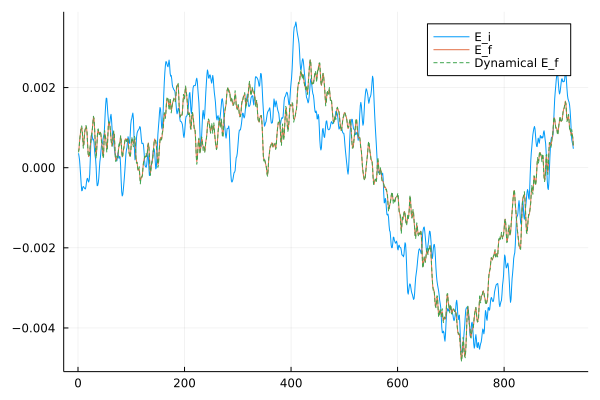

In [ ]:
#@bell sleep(3)
E_f = zeros(J)
#ϕ_f = zeros(J)
#n_f = zeros(J) #charge density
get_density!(u, n, par_grid)
get_ϕ!(ϕ, n .- 1.0, κ)
get_E_from_ϕ!(ϕ,E_f,dx)

plot(E_i, label="E_i")
plot!(E_f, label="E_f")
plot!(u[2N+1:end], ls=:dash, label="Dynamical E_f")

Saving the results

In [ ]:
if remote_server
    exit() #if running as script
end

## Studying the solutions: 

Post procesing is done in post_pro_landau_rel

### Energy:

34 peaks in T = 100, so $\omega = 0.34$

We save the data:

| time | order | energy | theta |
|------|-------|--------|-------|
|  40  |  1    | 7.4e-7 | 0.009978|
|  40  |  3    | 7.9e-8 | 0.009979 |
|  40  |  5    | 1.1e-7 | 0.009979 |
|  4000|  1    | 7.6e-5 | 0.009978 |
|  4000|  3    | 7.2e-6 | 0.010086 |
|  4000|  5    | 1.0e-5 | 0.010031 |
|  4e6 |  1    | 0.0360 | 0.010119 |
